# A Deep Learning Heteroscedastic Uncertainty Approach to Fault Detection of Wind Turbines using SCADA data 

In [1]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump

from utils import *
from models import *
from constants import *

2024-04-19 15:11:46.030805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 15:11:46.032313: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 15:11:46.051046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 15:11:46.051062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 15:11:46.051612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
if GPU:
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
    devices = tf.config.list_physical_devices('GPU')
    if devices:
        print("Using GPU")
    else:
        print("Using CPU")
    



Using CPU


2024-04-19 15:11:47.884391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 15:11:47.884589: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Data Analysis

In [3]:
keras.utils.set_random_seed(812)

In [4]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned/train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned/test.pkl','rb'))

In [5]:
df_train.head()

index           Date.time    Power.me    Power.sd   Power.min  \
0  103052 2019-10-09 15:40:00  612.931889  117.853113  397.738037   
1   63535 2018-12-22 19:20:00  812.563049  127.390045  596.425964   
2   30251 2018-04-23 07:00:00  833.015015  178.888748  529.766296   
3  138781 2020-06-16 05:20:00   -0.890103    0.124784   -1.120350   
4   94560 2019-08-11 16:20:00  820.504449  194.314092  514.688721   

     Power.max  Pot.Power.me  Wind.speed.me  Wind.speed.sd  Wind.speed.min  \
0   789.362366    625.268222       6.922316       0.775613        5.464120   
1   987.356689    623.877258       6.916840       0.837299        5.161180   
2  1154.555420    650.319405       7.015926       0.996402        5.118486   
3    -0.629530      0.000000       2.538888       0.296080        1.866375   
4  1285.431152    750.737509       7.316579       0.959171        5.956026   

   ...  Blade.ang.pitch.pos.C.sd  Blade.ang.pitch.pos.C.min  \
0  ...                       0.0                        0.0   
1  ...                       NaN                        NaN   
2  ...                       NaN                        NaN   
3  ...                       0.0                       45.0   
4  ...                       0.0                        0.0   

   Blade.ang.pitch.pos.C.max  Gear.oil.inlet.press.me  Gear.oil.pump.press.me  \
0                        0.0               102.134432              456.456093   
1                        NaN               137.115128              620.665283   
2                        NaN               149.870911              569.190796   
3                       45.0                61.487915              324.860234   
4                        0.0               154.446519              613.626147   

   Drive.train.acceleration.me  Tower.Acceleration.x  Tower.Acceleration.y  \
0                    10.481703             47.967646             26.137451   
1                     7.971515             37.439159             25.069386   
2                     9.258190             54.654232             34.426693   
3                     4.306723              5.041540              4.982683   
4                     8.222307             57.914969             32.184149   

   turbine  year  
0        1  2019  
1        1  2018  
2        1  2018  
3        1  2020  
4        1  2019  

[5 rows x 111 columns]

In [6]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]
df_train_single.reset_index(drop=True, inplace=True)
print(f"Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print(f"Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#5 Training Set Size:  807764
Turbine#5 Testing Set Size:  201943


In [7]:
descriptive_stats = df[FEATURES + [OUTPUT_FEATURE]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

Wind.speed.me  Wind.speed.sd  Wind.speed.min  Wind.speed.max  \
count  189381.000000  189381.000000   189381.000000   189381.000000   
mean        6.061792       0.929598        4.285672        7.826800   
std         2.767883       0.461186        2.206099        3.482993   
min         0.129863       0.000000       -0.444250        0.243750   
25%         4.052706       0.595049        2.674919        5.362026   
50%         5.707567       0.851638        4.071932        7.317771   
75%         7.657582       1.180467        5.618109        9.794380   
max        22.151195       5.016237       17.995665       32.264656   

       Front.bearing.temp.me  Front.bearing.temp.sd  Front.bearing.temp.min  \
count          189381.000000          189381.000000           189381.000000   
mean               65.249559               0.611390               64.235198   
std                10.096854               0.504141                9.916454   
min                14.565001               0.000000               14.400000   
25%                61.002500               0.236114               60.099998   
50%                69.794736               0.475730               68.449997   
75%                72.277500               0.845470               71.199997   
max                81.182500               7.816919               80.800003   

       Front.bearing.temp.max  Rear.bearing.temp.me  Rear.bearing.temp.sd  \
count           189381.000000         189381.000000         189381.000000   
mean                66.234087             63.228148              0.665511   
std                 10.287366              8.592414              0.576825   
min                 14.600000             13.147500              0.000000   
25%                 61.900002             61.092499              0.240885   
50%                 70.900002             66.140001              0.477723   
75%                 73.300003             68.575001              0.928453   
max                 81.449997             75.092500              7.473754   

       Rear.bearing.temp.min  Rear.bearing.temp.max  Rotor.bearing.temp.me  \
count          189381.000000          189381.000000          189381.000000   
mean               62.131779              64.294001              25.147016   
std                 8.409253               8.819052               3.963058   
min                13.100000              13.200000               9.002500   
25%                60.400002              61.849998              22.215000   
50%                65.050003              67.000000              25.049999   
75%                67.199997              70.000000              28.059524   
max                74.649994              76.400002              39.097499   

       Stator1.temp.me  Nacelle.ambient.temp.me  Nacelle.temp.me  \
count    189381.000000            189381.000000    189381.000000   
mean         62.680004                10.395775        19.545742   
std           7.853748                 5.895684         5.386682   
min          13.720000                -6.800000         1.245000   
25%          59.665001                 6.020000        15.917500   
50%          62.027500                 9.690000        19.530000   
75%          64.492499                14.352500        23.075000   
max         103.014999                35.225000        39.430000   

       Transformer.temp.me  Gear.oil.temp.me  Gear.oil.inlet.temp.me  \
count        189381.000000     189381.000000           189381.000000   
mean             48.827492         52.035799               48.283892   
std              19.850288          5.862262                8.085823   
min              18.690001         13.857500                9.235000   
25%              35.562500         49.326313               42.110000   
50%              42.087499         53.122500               50.200000   
75%              54.002631         56.322498               55.132500   
max             107.987503         59.926316               60.208335 

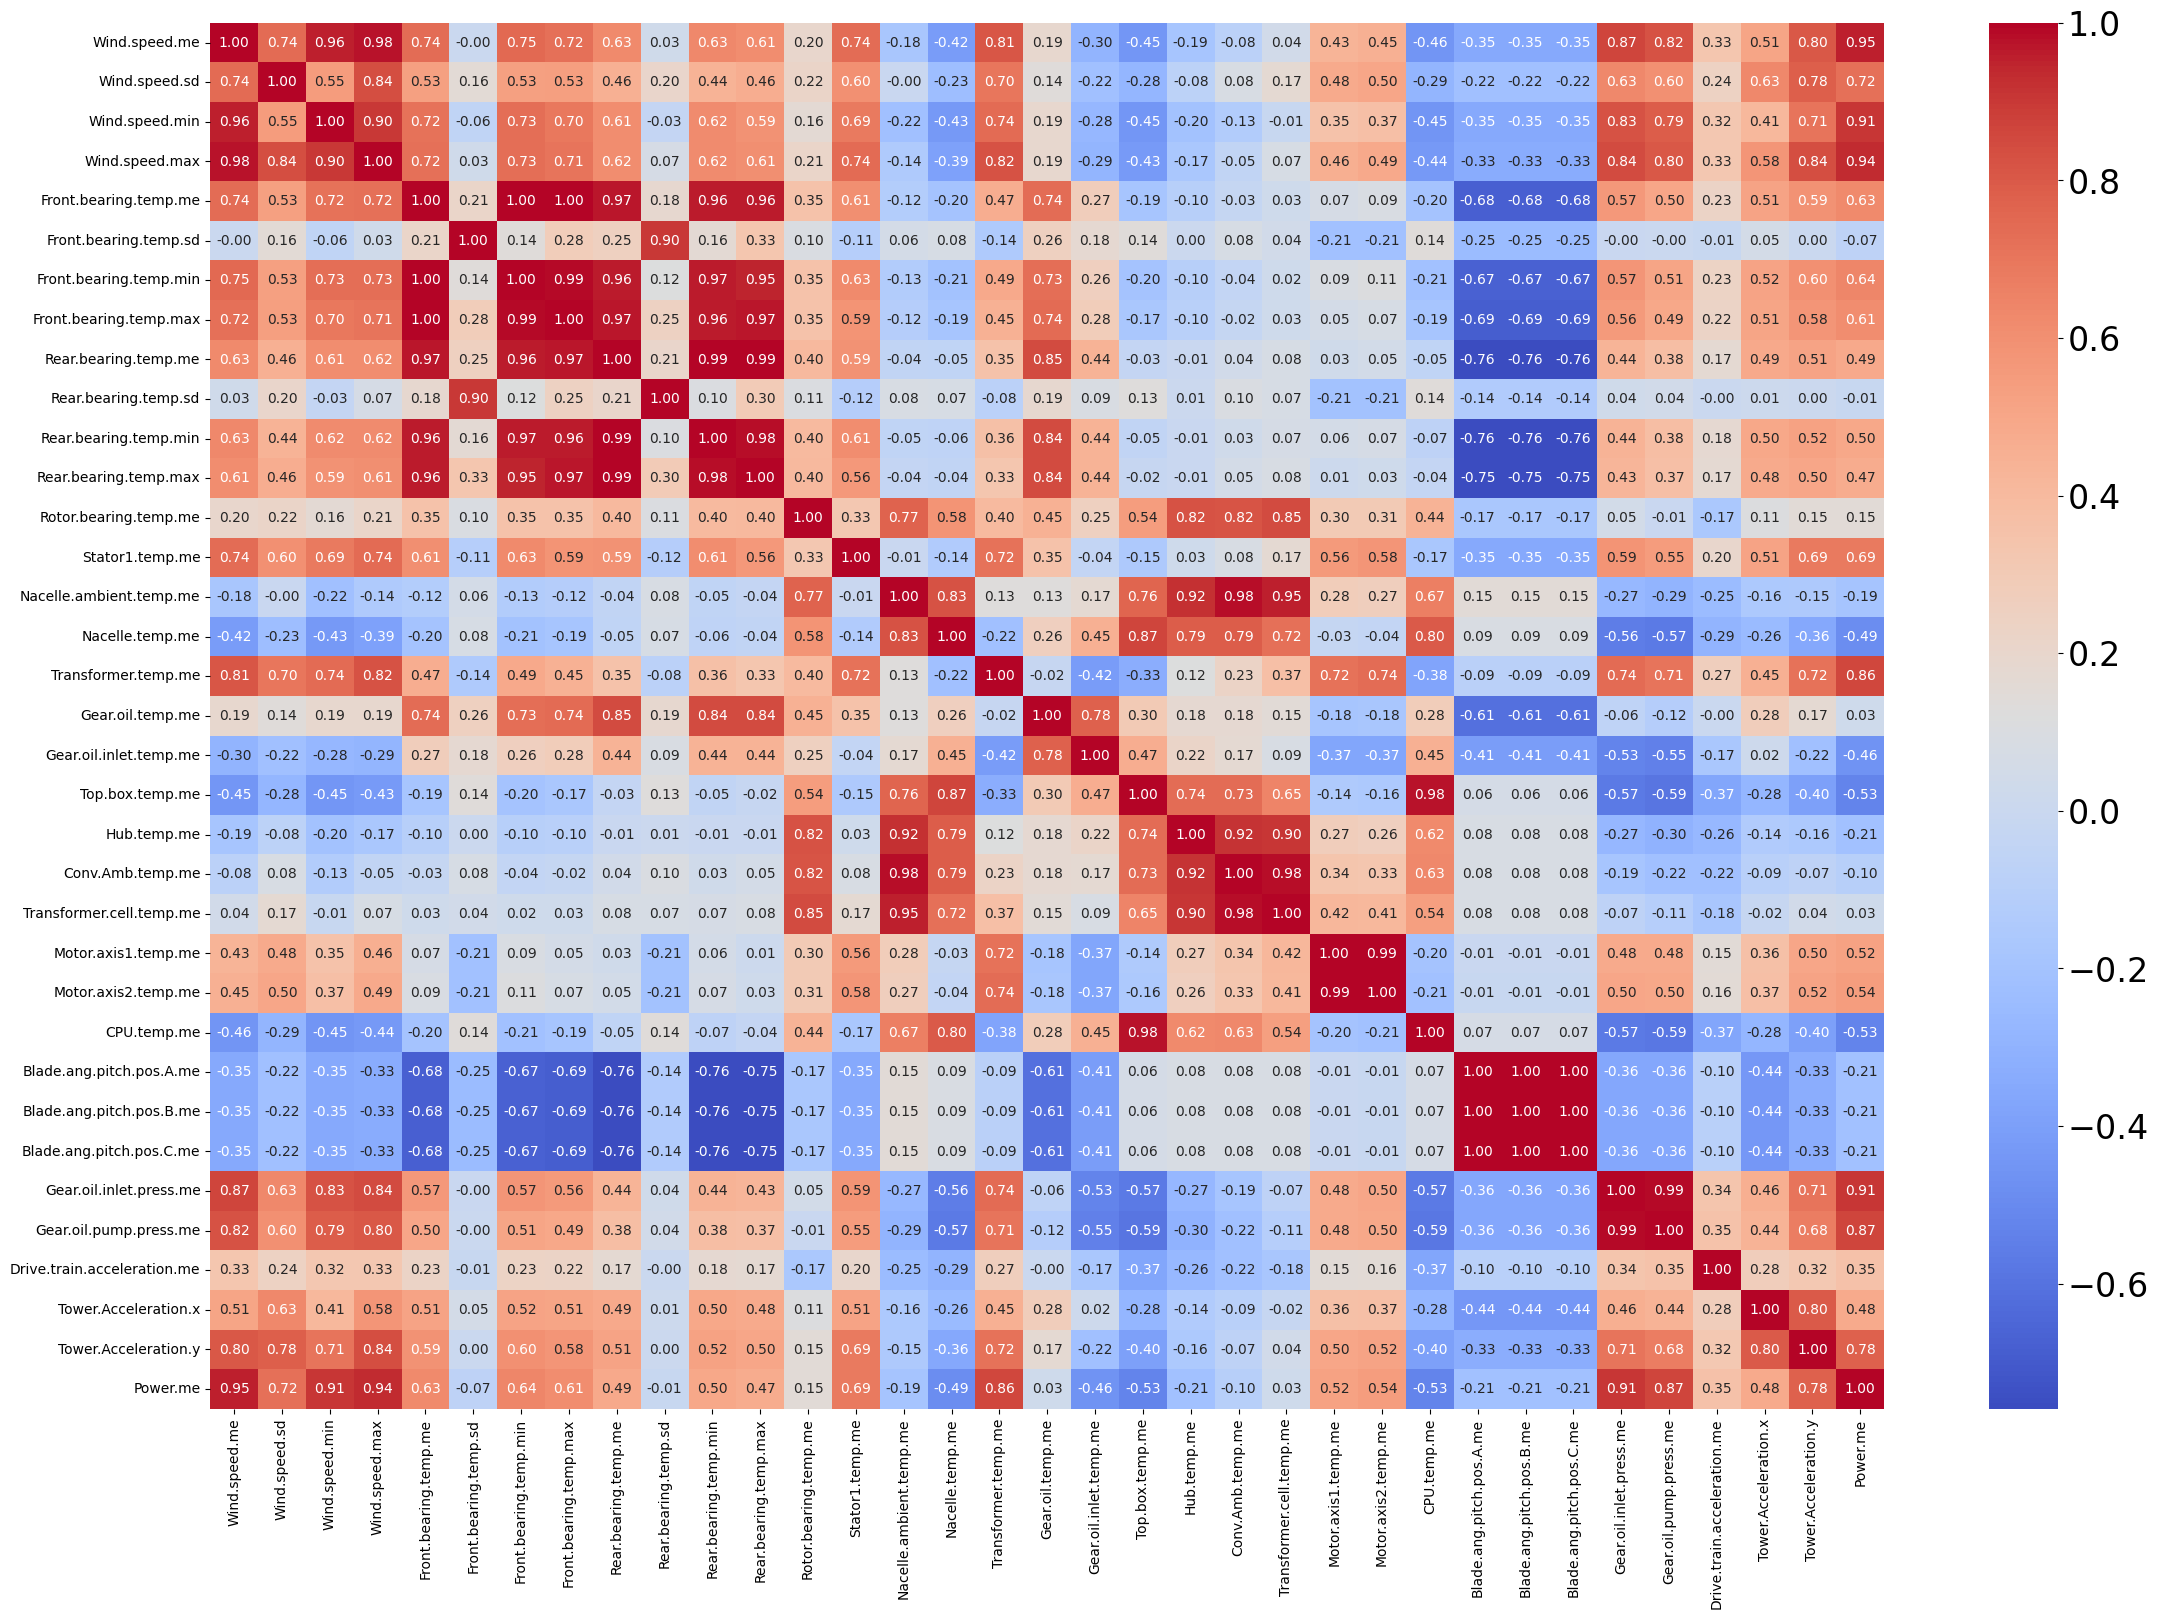

In [8]:
plt.figure(figsize=(27, 18))
correlation_matrix = df_train_single[FEATURES + [OUTPUT_FEATURE]].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

plt.show()

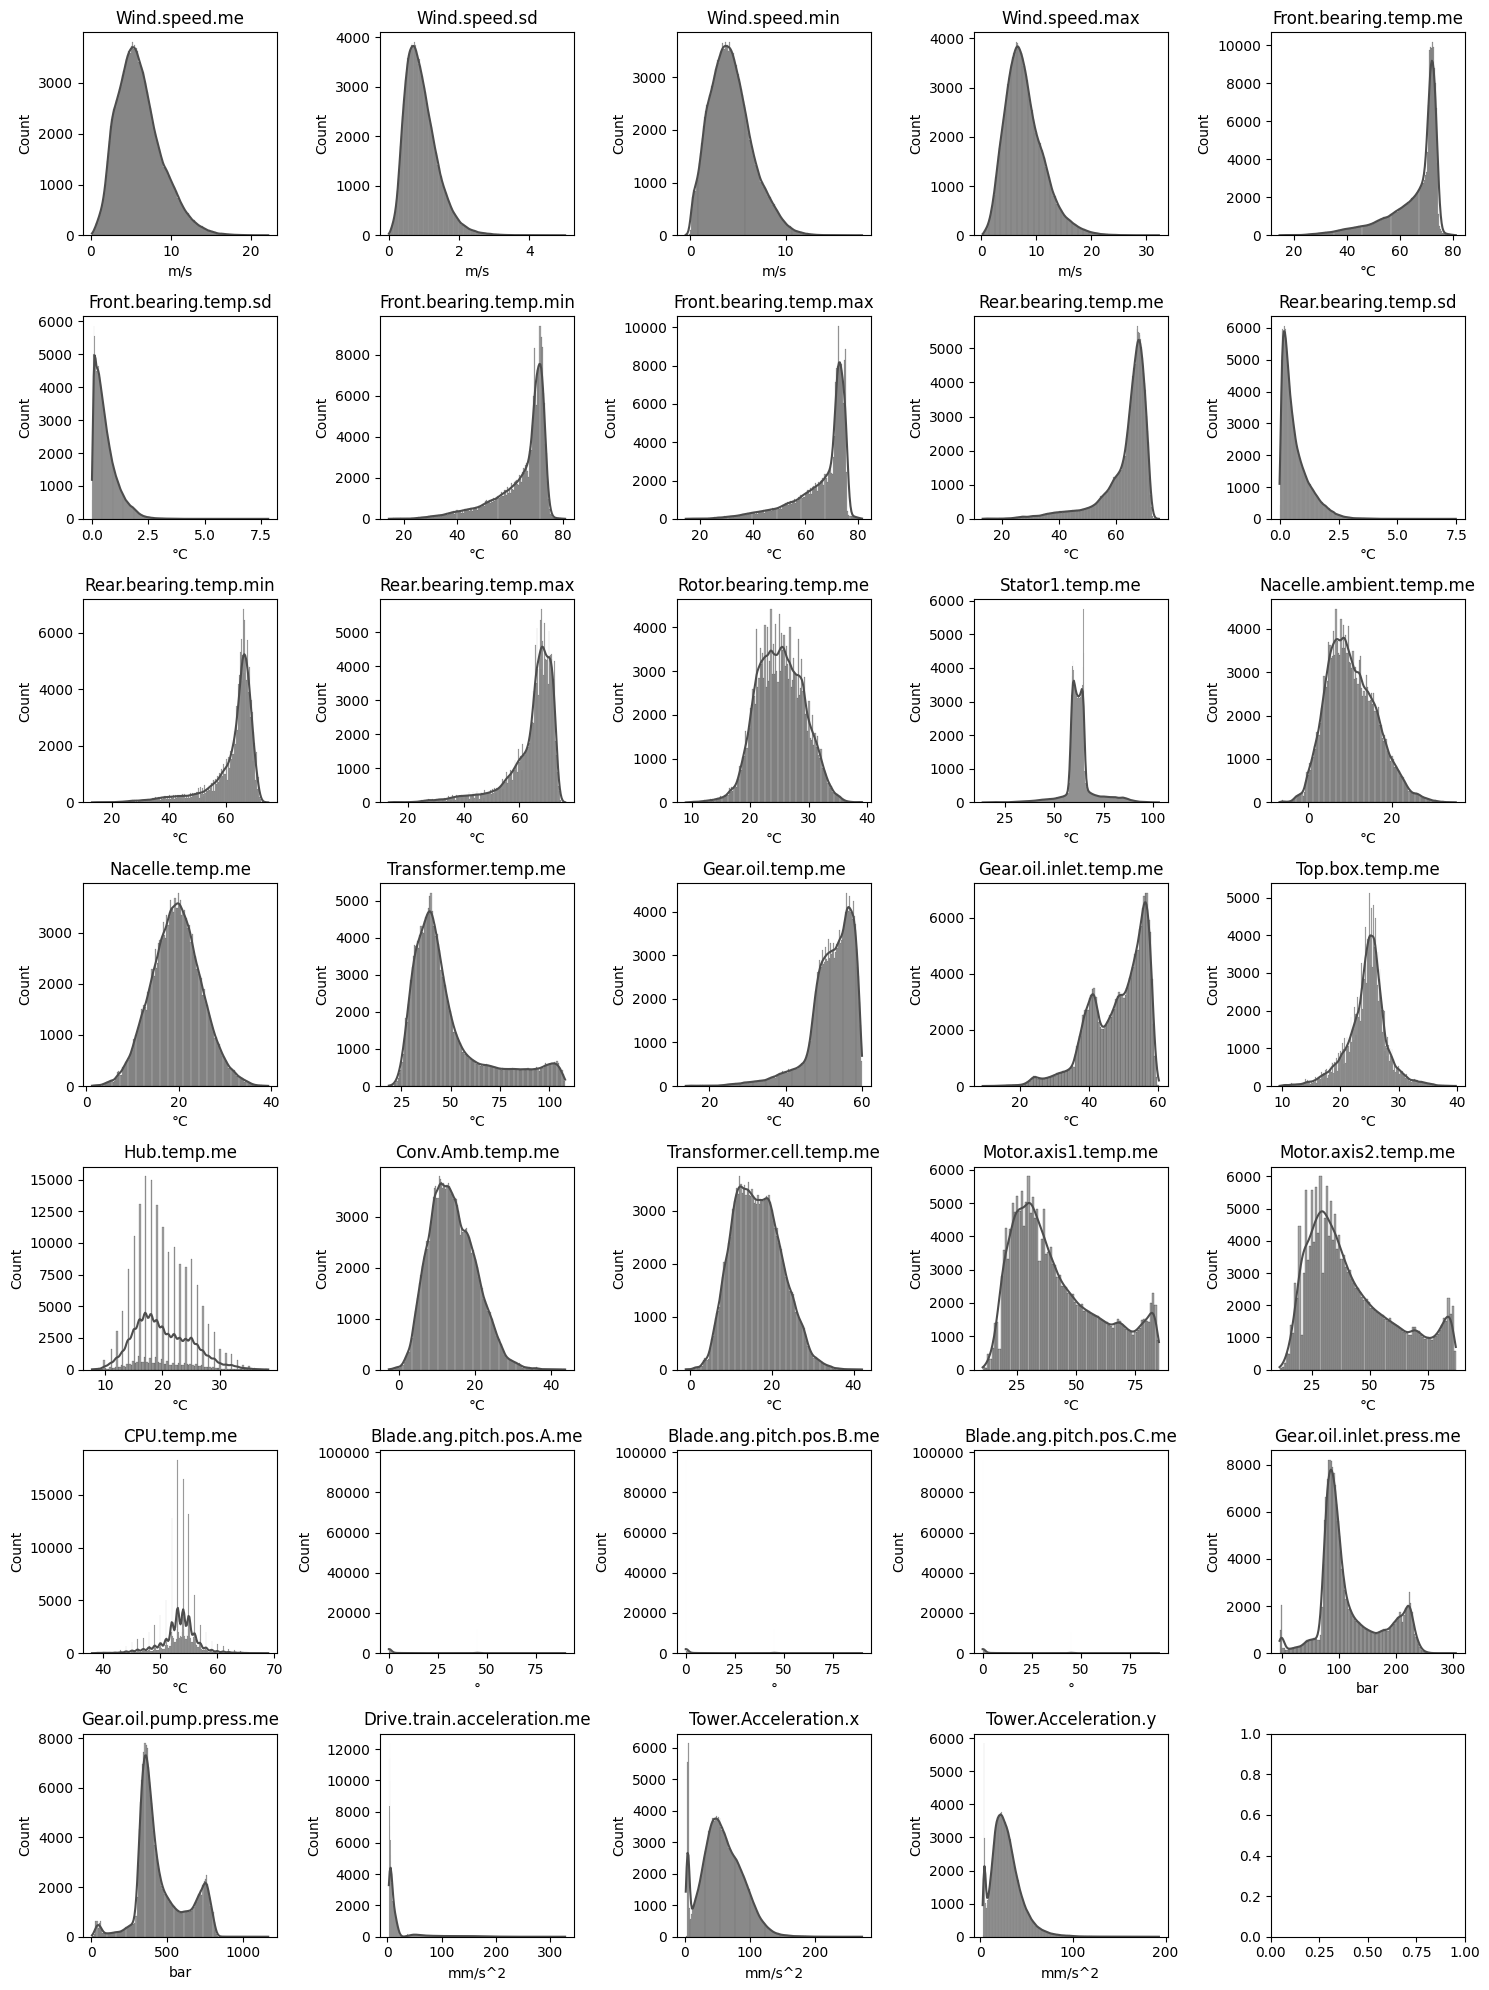

In [9]:
num_cols = 5
num_rows = math.ceil(len(FEATURES) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(FEATURES):
    sns.histplot(df[feature], kde=True, ax=axes[i], color="0.3")
    axes[i].set_title(feature)
    axes[i].set_xlabel(UNITS[feature])
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()

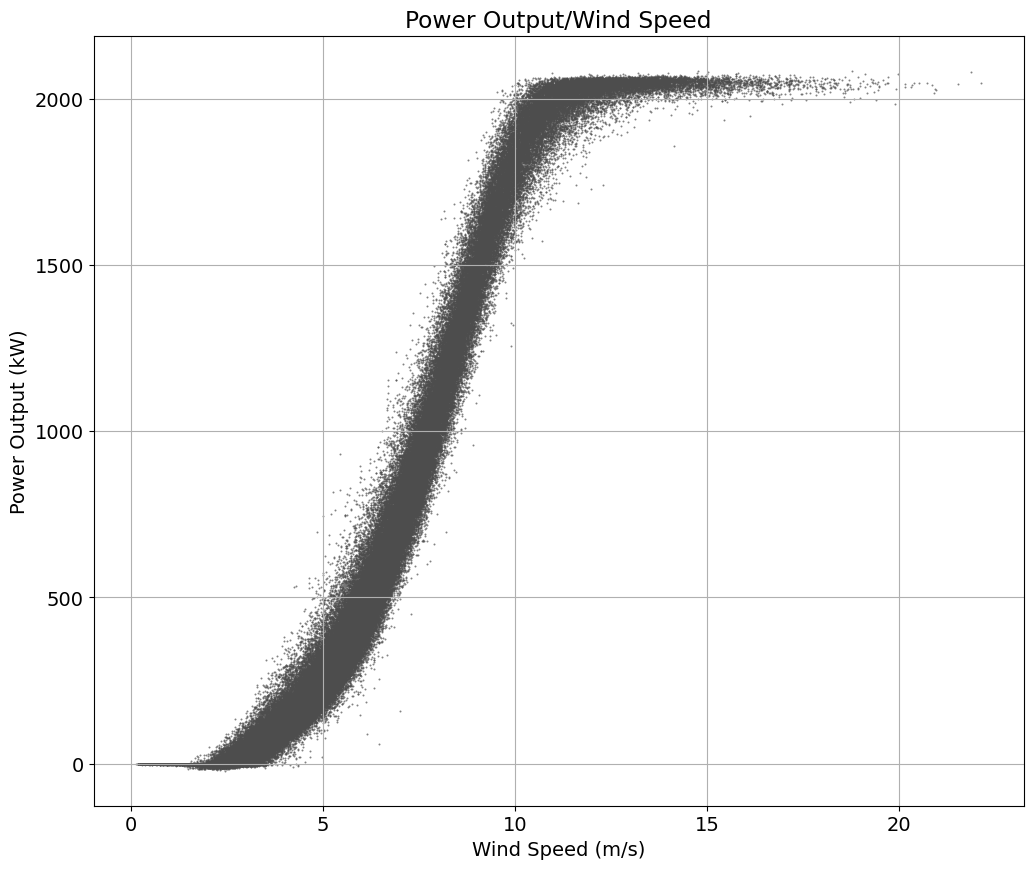

In [10]:
# Plot Power over Wind Speed
plt.rc('font', size=14)
plt.figure(figsize=(12, 10))
plt.scatter(df['Wind.speed.me'], df[OUTPUT_FEATURE], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

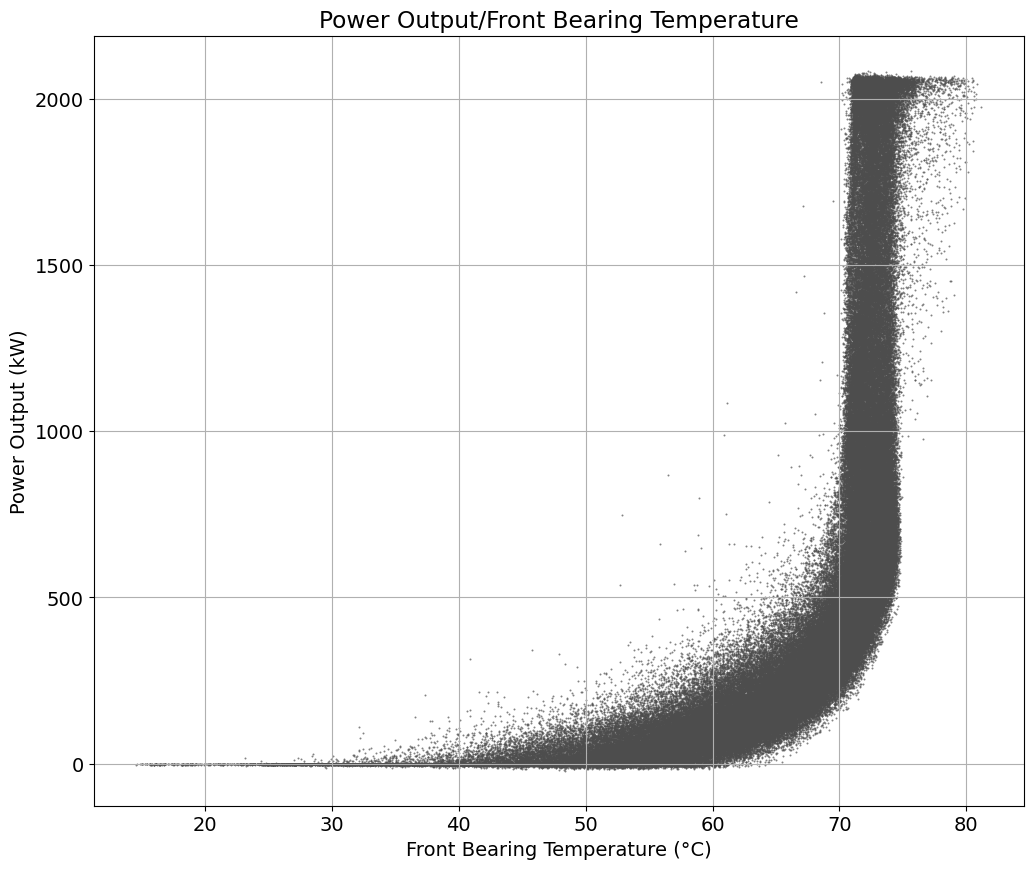

In [11]:
# Plot Power over Front Bearing Temperature
plt.rc('font', size=14)
plt.figure(figsize=(12, 10))
plt.scatter(df['Front.bearing.temp.me'], df[OUTPUT_FEATURE], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Front Bearing Temperature')
plt.xlabel('Front Bearing Temperature (°C)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

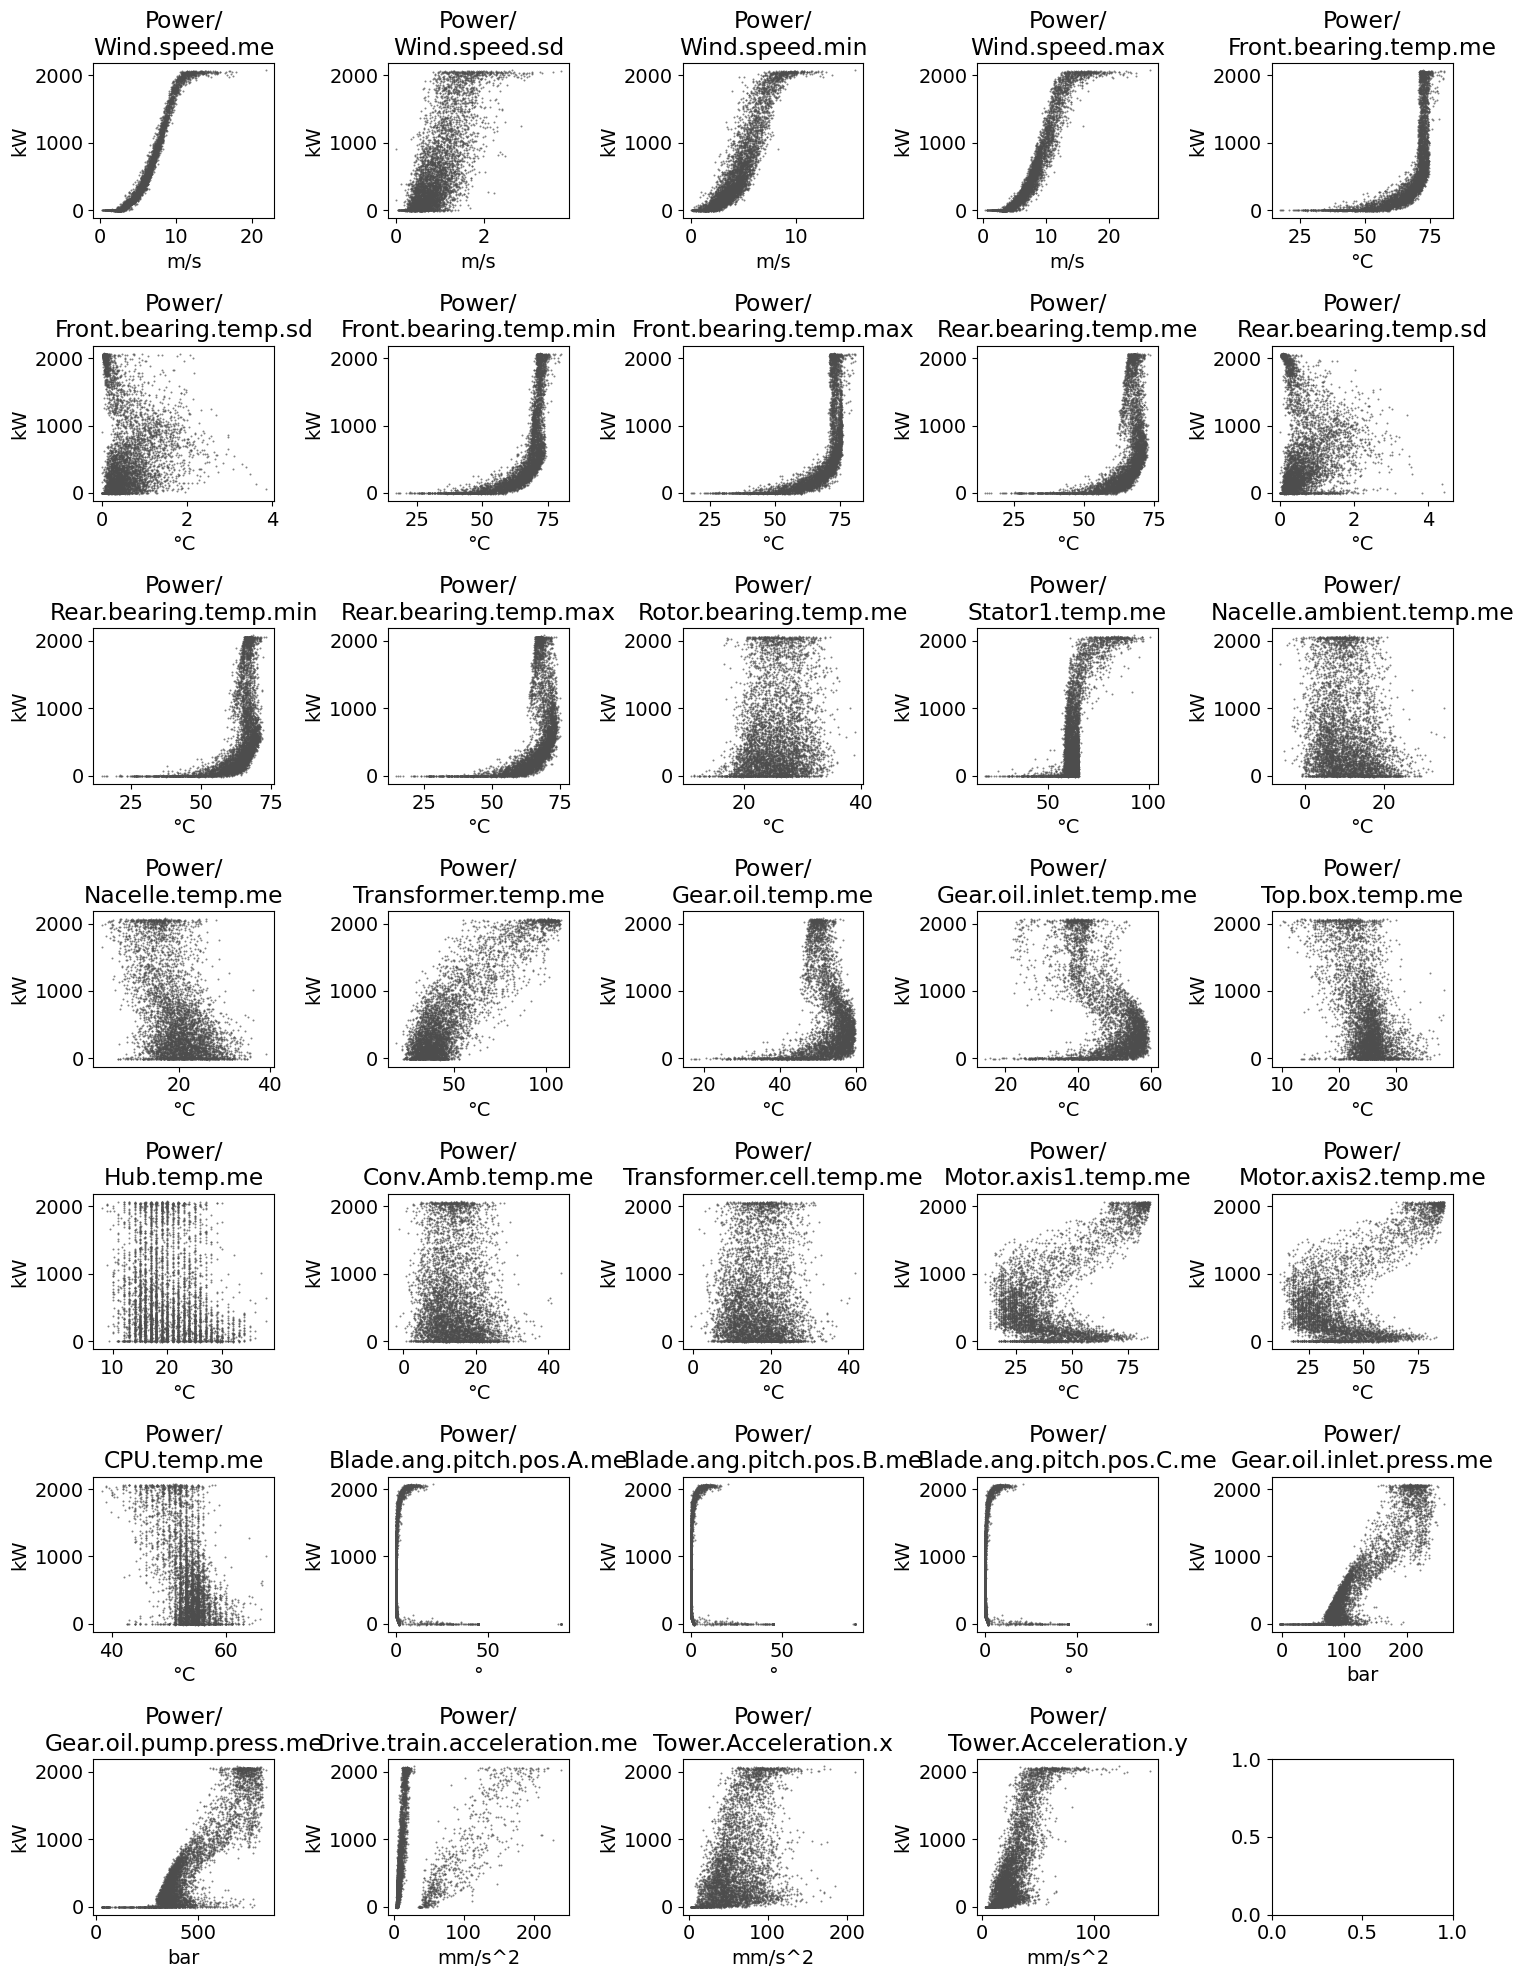

In [12]:
plot_power_over_all_features(df, UNITS, FEATURES, OUTPUT_FEATURE, sample_size=5000)

These plots show, first of all, the non-linearity relationship between power output and operatioanl variables, and secondly, how the variance can significantly vary within features domains

In [13]:
X_train_full, X_test_full,\
    y_train_full, y_test_full,\
    scaler_full = create_design_matrix(df_train, df_test, FEATURES, OUTPUT_FEATURE)

X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

dump(scaler, 'saved_models/scaler_full.joblib')
dump(scaler, 'saved_models/scaler.joblib')

assert X_train.shape[0] < X_train_full.shape[0]

In [14]:
X_train.shape

(151504, 34)

### Deterministic (Homoscedastic) MLP

We develop a deterministic multilayer perceptron (MLP) that uses as a loss function the mean squared error (MSE). The use of MSE as the loss function requires the assumption that the noise is identically and independently distributed accross the domain. The 'identically distributed' assumtpion assumes that the variance of the noise is not a function of the input parameters. Because of this, the deterministic MLP proposed below only accounts for homoscedastic sources of aleatoric and epistemic. However, the amount of error expressed by the model cannot be explicitly divided into epistemic and aleatoric uncertainty as the model does not explicitly output a distribution but a prediction. Confidence intervals can be derived as a function by assuming a gaussian distribution centred in the output of the network and with variance approximated by the MSE.

In [15]:
model_mlp_non_probabilistic = create_model_mlp_non_probabilistic(X_train, MODELS_SEED)
model_path = "mlp"

In [16]:
if TRAIN == True:
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic,
                          X_train, y_train,
                          patience=10, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense (Dense)               (None, 80)                2800      
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7891 (30.82 KB)
Trainable params: 7891 (30.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4262/4262 [====

KeyboardInterrupt: 

In [ ]:
model_mlp_non_probabilistic.load_weights(f"saved_models/{model_path}.weights.h5")
model_mlp_non_probabilistic.evaluate(X_test, y_test)

1184/1184 [==============================] - 0s 286us/step - loss: 775.6079


775.60791015625

In [ ]:
y_train_pred = np.array(model_mlp_non_probabilistic.predict(X_train)).ravel()
y_test_pred = np.array(model_mlp_non_probabilistic.predict(X_test)).ravel()

# We approximate the standard deviation of the assumed gaussian noise by using the RMSE of the prediction. This also assumes
# homoscedasticity nature of the noise.
y_train_stddevs = np.full(len(y_train_pred), np.sqrt(mean_squared_error(y_train, y_train_pred)))
y_test_stddevs = np.full(len(y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred)))

evaluate_and_save_metrics("Non-probabilistic MLP",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

1184/1184 [==============================] - 0s 269us/step
Train RMSE: 27.268
Test RMSE: 27.850
Train MAE: 16.322
Test MAE: 16.586
Percentage of Test Data Points within 99.00% CI: 96.26%
Percentage of Test Data Points within 99.00% CI: 96.24%
Percentage of Test Data Points within 99.00% CI: 93.30%
Percentage of Test Data Points within 99.00% CI: 93.21%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


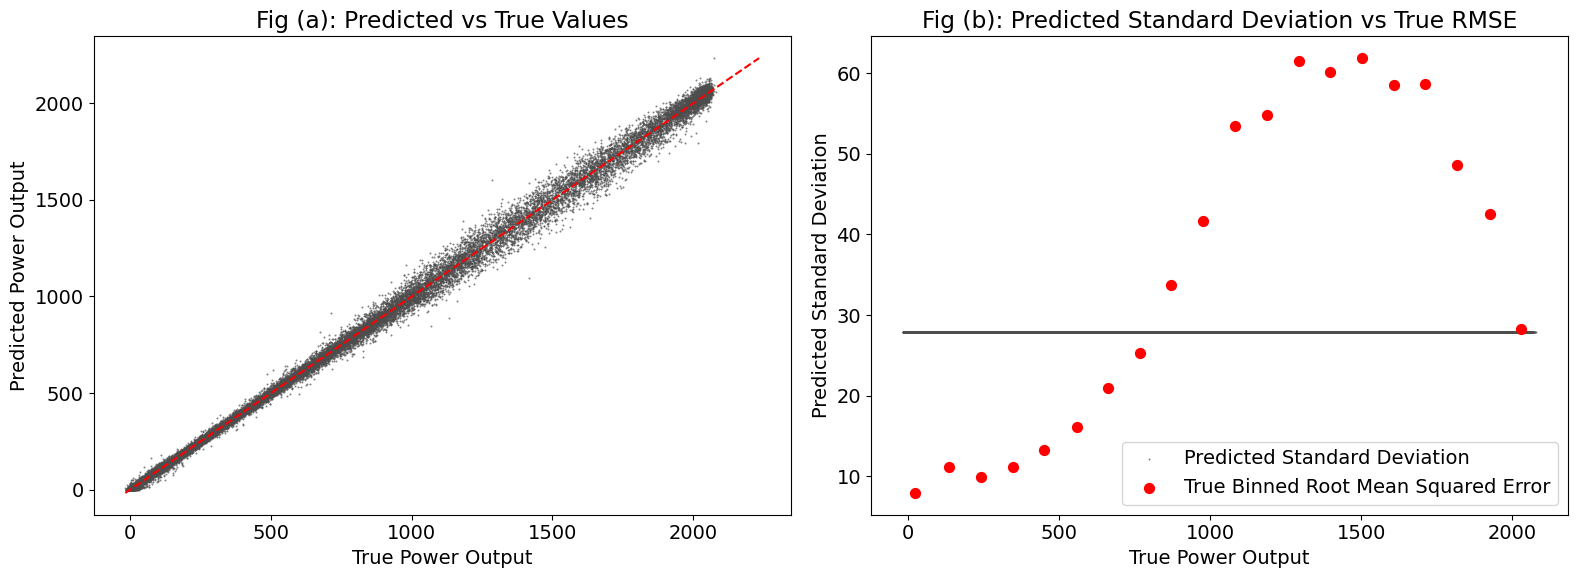

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

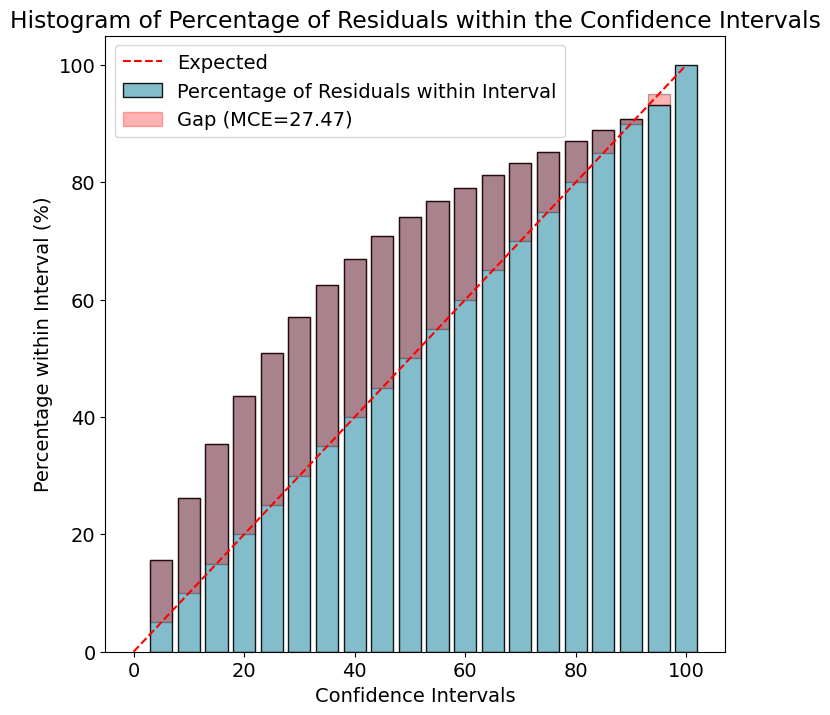

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

As you can see, althought the standard non-probabilistic neural network is an excellent approximator of the non linear relationship between SCADA variables and power output, as shown by the low RMSE, it is not a good model for evaluating uncertainty in prediction. It poorly overestimates uncertainty for power outputs, underestimates noise for mid-high power outputs, and again overestimates noise for the power outputs approaching 2000kW.

## Bayesian Neural Networks (/Deterministic Output)

The purpose of introducing Bayesian Inference in neural networks is to introduce an estimation of the epistemic uncertainty (i.e., the uncertainty of the model - reducible with further training) of the model. In this framework, the model's weights are represented as posterior distributions instead of point-estimates. Therefore, as compared to traditional neural networks, the purpose of Bayesian Neural Network is to infere weight distributions from which an output given an input can be sampled. This represents the uncertainty of the model due to lack of data coverage. Typically, we expect epistemic uncertainty to be quite low for SCADA data sets as they provide large availability of data. 

BNN models are typically employed in data scarse systems, where identifying the uncertainty due to the lack of sufficient training is paramount. Because our dataset contains over 150,000 data entries, we expect low levels of epistemic uncertainty. This because it is possible to reduce epistemic uncertainty by giving the model sufficient representability capacity and train it over a sufficiently large dataset with respect to the number of model parameters. Nevertheless, we explore the use of BNN with deterministic output and probabilistic weights as a baseline model, and to show that most of the uncertainty in our regression task is given by irreducible noise and confirm that this is input-dependent. The models presented below leverage the approximate Bayesian Inference approach using Dense Flipout hidden layers. However, they have a non-probabilistic output, meaning it is unable to express heteroscedastic sources of aleatoric uncertainty. Again, because it minimizes the MSE, it assumes the data is distributed around an unknown function we are trying to approximate with an additive noise with homoscedastic variance.  

In particular, because of the higher computational complexity associated with BNNs as compared to standard neural networks, we have to reduce the size of our dataset to a 1% random sample.

In [ ]:
SAMPLE_PERCENTAGE = 0.01
np.random.seed(MODELS_SEED)

sampled_indices = np.random.choice(len(X_train), int(len(X_train) * SAMPLE_PERCENTAGE), replace=False)
X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

### Dense Flipout Layers (sample data set)

Below it is presented a Bayesian multilayer perceptron (MLP) which approximates bayesian inference using Variational Inference via Flipout [1]. We specify Normal distributions with trainable parameters as weights for all hidden layers. In this case, we have an heteroscedastic epistemic and homoscedastic aleatoric model. The heteroscedasticity nature of the represented model uncertainty is derived through the use of probability distributions as weights, while the noise is still modelled with fixed variance (aleatoric homoscedasticity) because the network has a deterministic output that minimizes the MSE (this is equivalent to Maximum A Posteriori estimation of a symmetric distribution).


[1] Wen, Y., Vicol, P., Ba, J., Tran, D., & Grosse, R. (2018). Flipout: Efficient Pseudo-Independent weight perturbations on Mini-Batches. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1803.04386

In [ ]:
model_bnn_non_probabilistic_flipout_sample, _ = create_model_bnn_non_probabilistic_flipout(X_train_sampled, MODELS_SEED)
model_path = "bnn_non_prob_sample"

/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/.venvfyp2/lib64/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/.venvfyp2/lib64/python3.9/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_flipout (DenseFlipou  (None, 30)                4110      
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 30)                3630      
 out)                                                            
                                                                 
 dense_flipout_3 (DenseFlip  (None, 1)                 121       
 out)                                                            
                                                                 
Total params: 7861 (30.71 KB)
Trainable params: 7861 (30.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

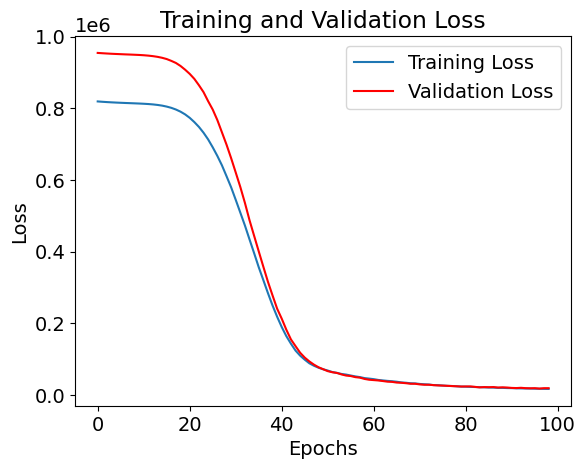

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_bnn_non_probabilistic_flipout_sample,
                          X_train_sampled, y_train_sampled,
                          patience=20, epochs=HUNDRED, batch_size=256,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_bnn_non_probabilistic_flipout_sample.load_weights(f"saved_models/{model_path}.weights.h5")
model_bnn_non_probabilistic_flipout_sample.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 429us/step - loss: 16431.7852


16431.78515625

In [ ]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_bnn_non_probabilistic_flipout_sample, X_train, X_test, num_samples=TWENTY)

1184/1184 [==============================] - 0s 386us/step


In [ ]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_save_metrics(f"Epistemic Uncertainty BNN (Flipout) - {SAMPLE_PERCENTAGE*100}% Sample", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 124.985
Test RMSE: 124.925
Train MAE: 92.537
Test MAE: 92.370
Percentage of Test Data Points within 99.00% CI: 16.94%
Percentage of Test Data Points within 99.00% CI: 17.17%
Percentage of Test Data Points within 99.00% CI: 13.07%
Percentage of Test Data Points within 99.00% CI: 13.27%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


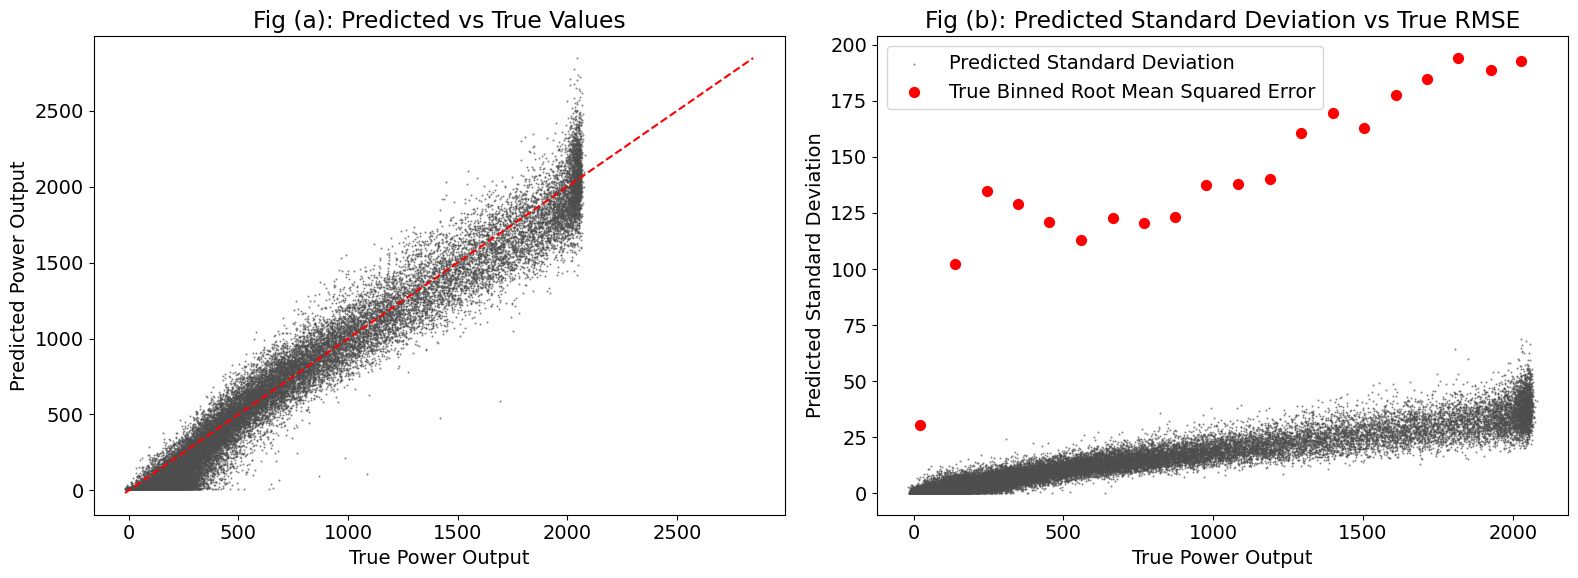

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

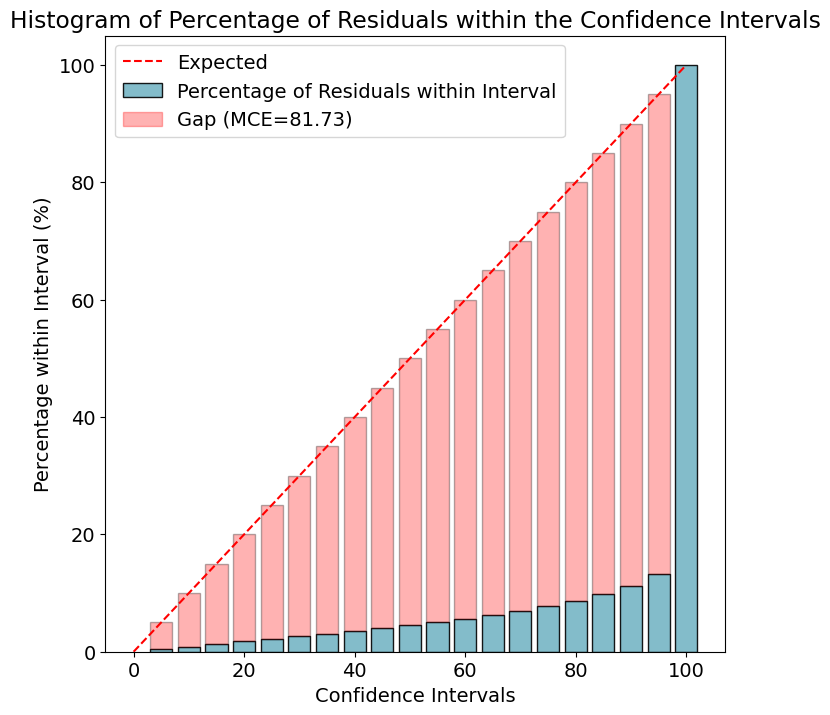

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

The RMSE of the of the model is high. We explore if this can be reduced with further training by considering the full training data set.

### Dense Flipout Layers (full data set)

An equivalent model as shown above, but trained over the full dataset. We show how further training can reduce epistemic uncertainty and decrease the prediction error of the model. However, we show how this is not fully representative of the uncertainty in the system, since most of the uncertainty is given by the variance of the noise, which we cannot model with a deterministic output.

In [ ]:
model_bnn_non_probabilistic_flipout, _ = create_model_bnn_non_probabilistic_flipout(X_train, MODELS_SEED)
model_path = "bnn_non_prob"

/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/.venvfyp2/lib64/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/.venvfyp2/lib64/python3.9/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_flipout_4 (DenseFlip  (None, 30)                4110      
 out)                                                            
                                                                 
 dense_flipout_5 (DenseFlip  (None, 30)                3630      
 out)                                                            
                                                                 
 dense_flipout_7 (DenseFlip  (None, 1)                 121       
 out)                                                            
                                                                 
Total params: 7861 (30.71 KB)
Trainable params: 7861 (30.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

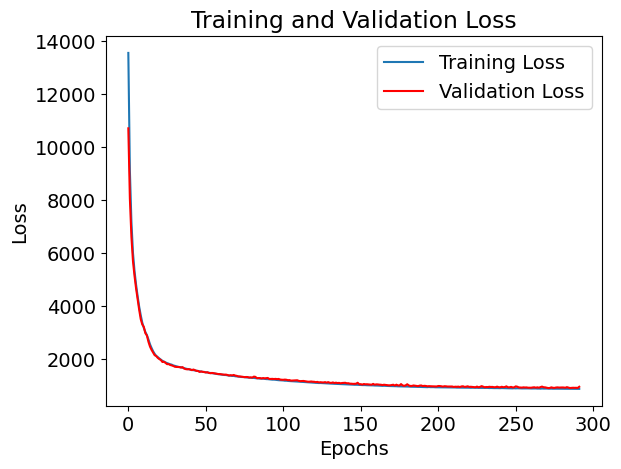

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/{model_path}.weights.h5",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_bnn_non_probabilistic_flipout,
                          X_train, y_train,
                          patience=20, epochs=4*HUNDRED, batch_size=256,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
# Load the model weights
model_bnn_non_probabilistic_flipout.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_bnn_non_probabilistic_flipout.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 423us/step - loss: 897.5259


897.52587890625

In [ ]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_bnn_non_probabilistic_flipout, X_train, X_test, num_samples=TWENTY)

1184/1184 [==============================] - 0s 370us/step


In [ ]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_save_metrics("Epistemic Uncertainty BNN (Flipout)", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\safe\utils.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


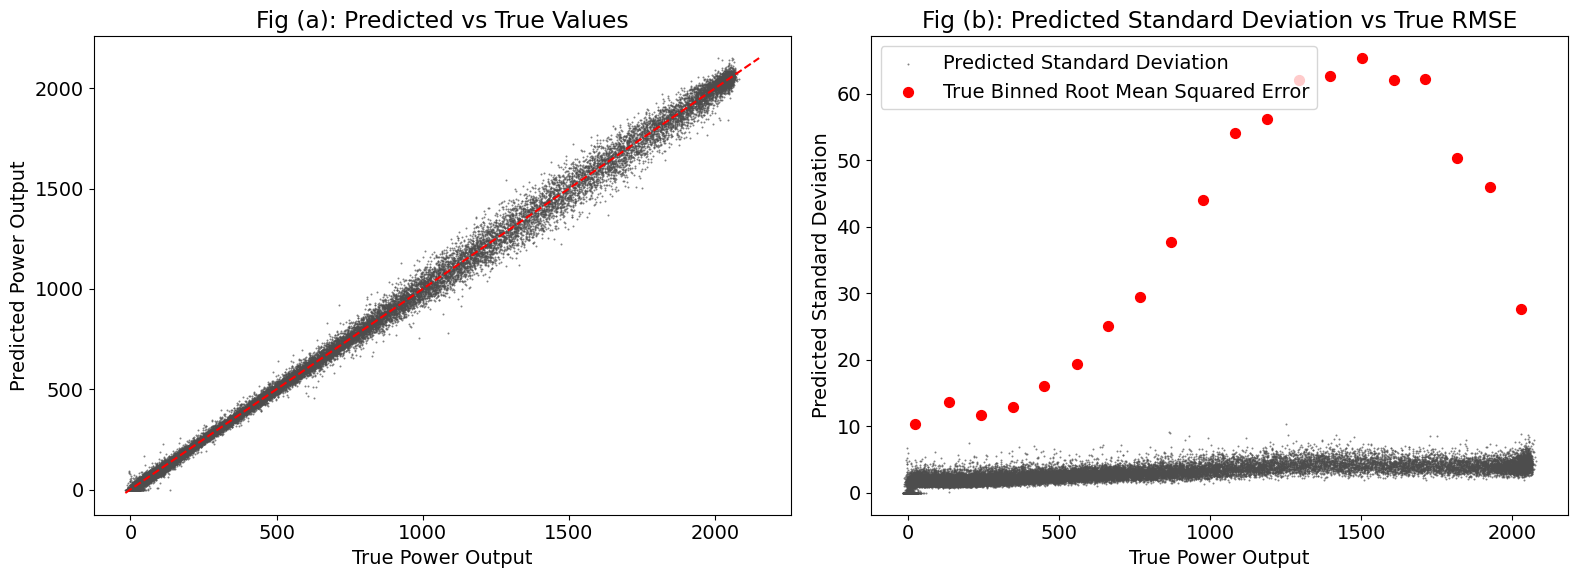

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\safe\utils.py:345: RuntimeWarning: invalid value encountered in multiply
  lower_bounds = y_test_pred.ravel() - t_value * y_test_std
c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\safe\utils.py:346: RuntimeWarning: invalid value encountered in multiply
  upper_bounds = y_test_pred.ravel() + t_value * y_test_std


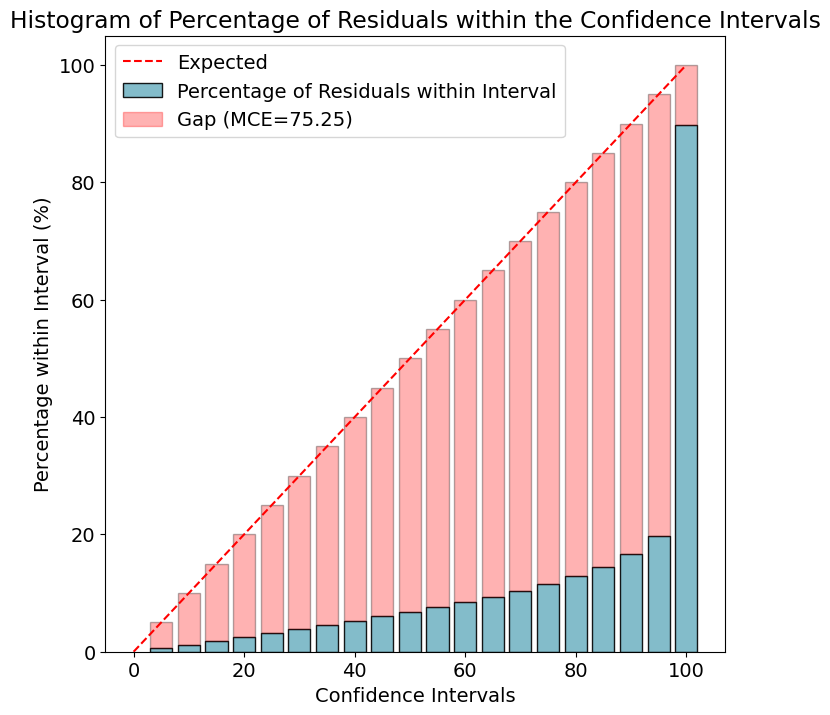

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

##### Feature Importance

For the interest of the field we evaluate the raw feature importance within the Bayesian network. Let's evaluate feature importance for the BNN with deterministic output. We do this only for the deterministic output because the RATE library does not support probabilistic regressions (see https://github.com/lorinanthony/RATE). To do so we retrain the model wrapped into a BNN_Regressor class from the RATE library.

For installation, see https://github.com/lorinanthony/RATE/tree/master/Software/rate-bnn

In [ ]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    from rate import *
    
    p = X_test.shape[1]

    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)

    _, layers = create_model_bnn_non_probabilistic_flipout(X_train, MODELS_SEED)

    bnn = BNN_Regressor(layers, p=p)
    fit_history = bnn.fit(X_train, y_train, epochs=HUNDRED//2, batch_size=256, validation_split=0.1,
                        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
                        verbose=0)

    sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
    X_test_sampled = X_train[sampled_indices]
    y_test_sampled = y_train[sampled_indices]

    rates = RATE_BNN(bnn, X_test_sampled, n_workers=1)
    feature_importance = {feature: rate for feature, rate in zip(FEATURES, list(rates[0]))}

In [ ]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    features = list(feature_importance.keys())
    importance_values = list(feature_importance.values())

    plt.figure(figsize=(10, 12))
    plt.barh(features, importance_values, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')

    for i, importance in enumerate(importance_values):
        plt.text(importance, i, f'{importance*100:.2f}', va='center')

    plt.xlim(0, max(importance_values) + 0.02)
    plt.tight_layout()
    plt.show()

While the deterministic Bayesian deep model presents very low RMSE, it is a poor approximator of the overall uncertainty of the model. This because it can only express the intrinsic uncertainty of the model caused by insufficient training or lack of expressivity of the model. However, since the epistemic uncertainty is evaluated as very low, it appears that the prediction residuals of the model are mostly caused by noise, which we cannot fully model with a non-probabilistic output. Moreover, the epistemic uncertainty is estimated as independent of the output true values.

## Bayesian Neural Networks (Probabilistic Output)

We introduce a probabilistic output to a bayesian netwrok with the same number of layers as the previous but more hidden units. This way we model the output as a univariate distribution parametrized via a mean and a variance functions in the input space of the network. The loss becomes the negative log-likelihood of the identically and indipendently distributed data points. Where the distribution is a univariate Normal with a mean function and variance function paramettrized by the model.

### Dense Flipout + Gaussian Output

In [ ]:
model_bnn = create_model_bnn(X_train, MODELS_SEED)
model_path = "bnn"

c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\safe\.venvfyp\Lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\safe\.venvfyp\Lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_bnn,
                          X_train, y_train,
                          patience=10, epochs=HUNDRED, batch_size=256,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_bnn.load_weights(f"saved_models/{model_path}.weights.h5")
model_bnn.evaluate(X_test, y_test)

OSError: Unable to synchronously open file (bad object header version number)

In [ ]:
y_train_pred = np.array(model_bnn(X_train).mean()).ravel()
y_test_pred = np.array(model_bnn(X_test).mean()).ravel()

y_train_stddevs = np.array(model_bnn(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_bnn(X_test).stddev()).ravel()

name = "Stochastic Output BNN (Flipout)"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 29.670
Test RMSE: 30.075
Train MAE: 16.281
Test MAE: 16.450
98.44%
98.32%
94.78%
94.70%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


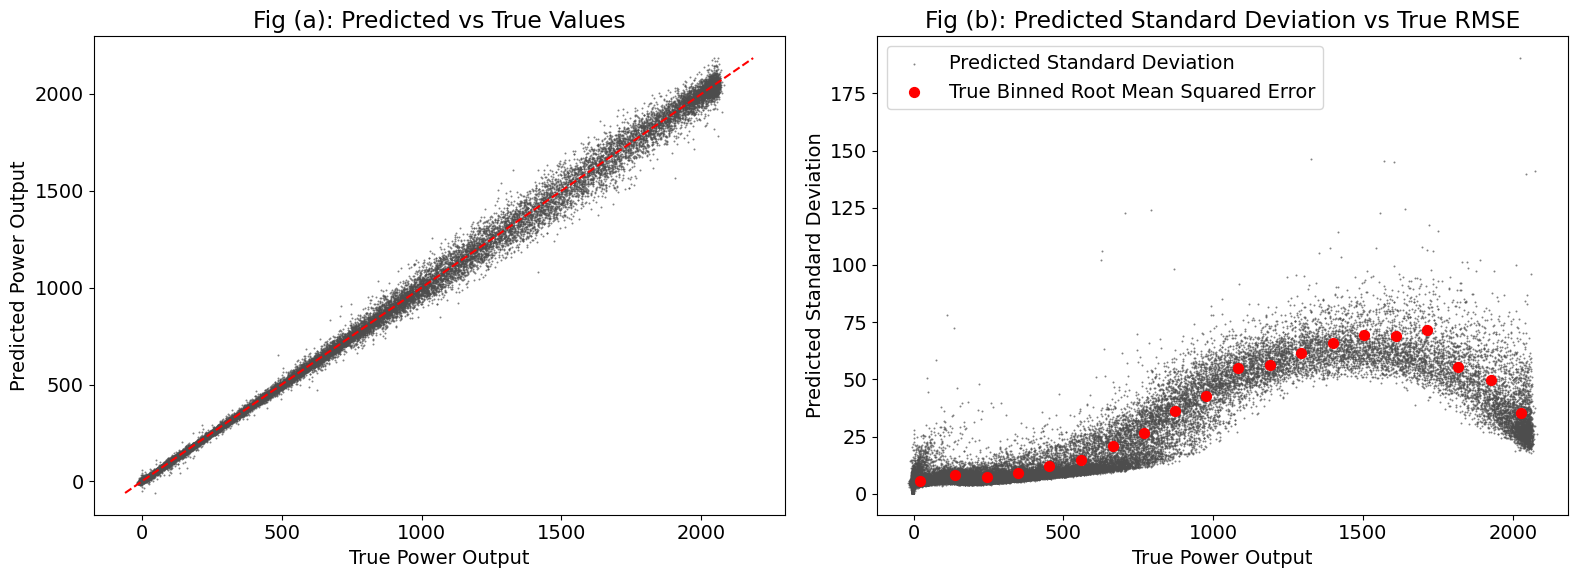

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

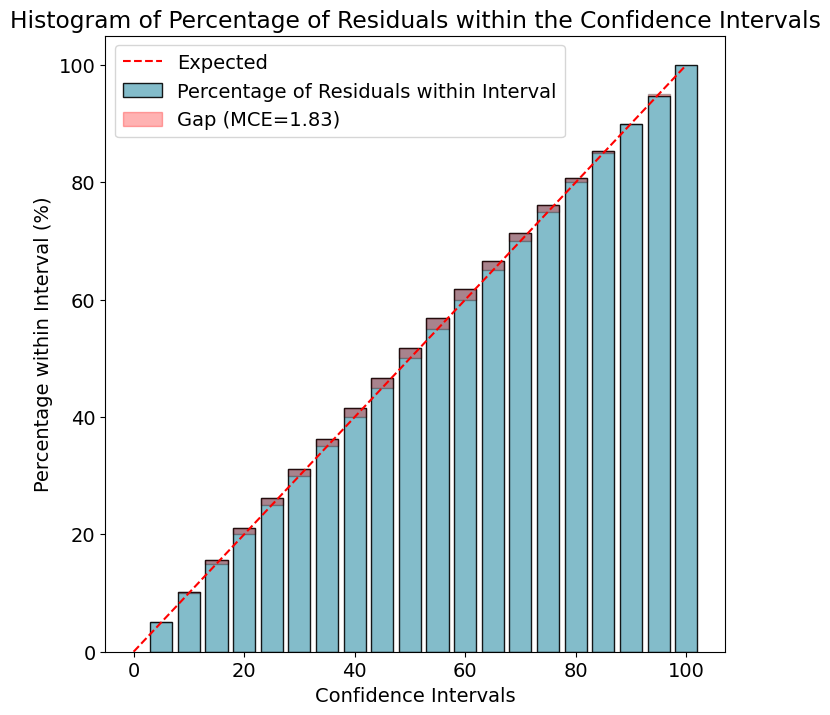

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

## Non-Bayesian MLP (Probabilistic Output) 
We create a non-Bayesian deep model for the mean and the standard deviation of a Gaussian. 

### MLP with Normal Output - Separate Submodels

Two identical and parallel networks process the input data independently to estimate the mean and variance parameters. These two sub-models employ three hidden layers with ReLU activation functions to capture non-linearity in the system with increasing levels of abstraction. The final layers of these sub-models are merged into a single output layer with two units, one for the predicted mean and one for the predicted variance). The loss is the negative log-likelihood of the Normal parametrized by these sub-models. This means, that, although the two sub-models extract independent non-linear features, they are trained simultaneously to minimize a common loss. 

In [ ]:
model_mlp_gaussian_separate = create_model_mlp_gaussian_separate(X_train, MODELS_SEED)
model_path = "mlp_sep"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/{model_path}.weights.h5",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_separate,
                          X_train, y_train,
                          patience=15, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_mlp_gaussian_separate.load_weights(f"saved_models/{model_path}.weights.h5")
model_mlp_gaussian_separate.evaluate(X_test, y_test)

1184/1184 [==============================] - 3s 2ms/step - loss: 5.0040


5.004029273986816

In [ ]:
y_train_pred = np.array(model_mlp_gaussian_separate(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_separate(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_separate(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_separate(X_test).stddev()).ravel()

evaluate_and_save_metrics("Probabilistic MLP (Separate Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 49.153
Test RMSE: 49.054
Train MAE: 30.162
Test MAE: 30.067
Percentage of Test Data Points within 99.00% CI: 93.39%
Percentage of Test Data Points within 99.00% CI: 93.31%
Percentage of Test Data Points within 99.00% CI: 86.96%
Percentage of Test Data Points within 99.00% CI: 86.98%


In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

### MLP with Gaussian Output - Joint Submodels

A shared deep feature extractor sub-model is followed by two shallow sub-models with a single hidden layer and a single-unit output layer respectively. The first shared sub-model extract non-linear features from the input space, and the separate models estimate mean and variance respectively using non-linear combinations of the features extracted by the shared sub-model. The two single-unit outputs of the mean and variance sub-models are concatenated to represent the parameters of a univariate Normal.

In [ ]:
model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, MODELS_SEED)
model_path = "mlp_joint"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_mlp_gaussian_joint.load_weights(f"saved_models/{model_path}.weights.h5")
model_mlp_gaussian_joint.evaluate(X_test, y_test)

ValueError: Layer 'dense_18' expected 2 variables, but received 0 variables during loading. Expected: ['dense_18/kernel:0', 'dense_18/bias:0']

In [ ]:
y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

name = "Prob. MLP"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 27.144
Test RMSE: 28.194
Train MAE: 14.468
Test MAE: 14.988
98.76%
98.37%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


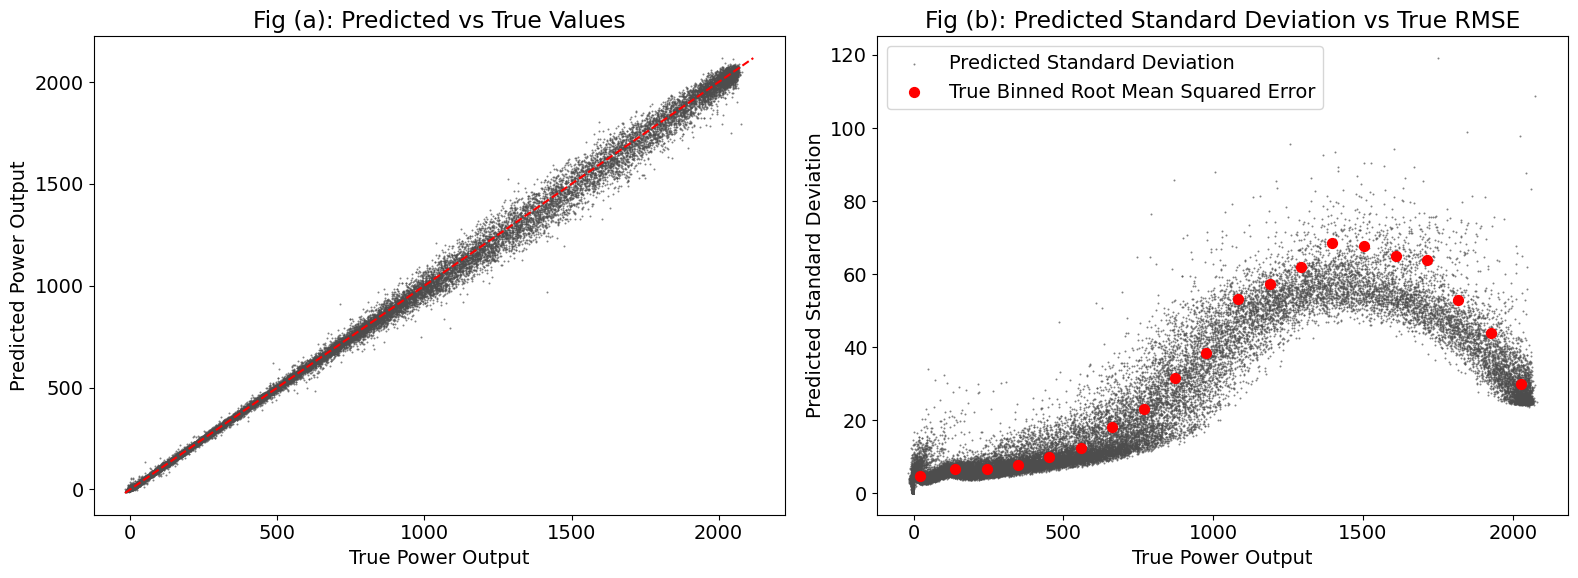

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

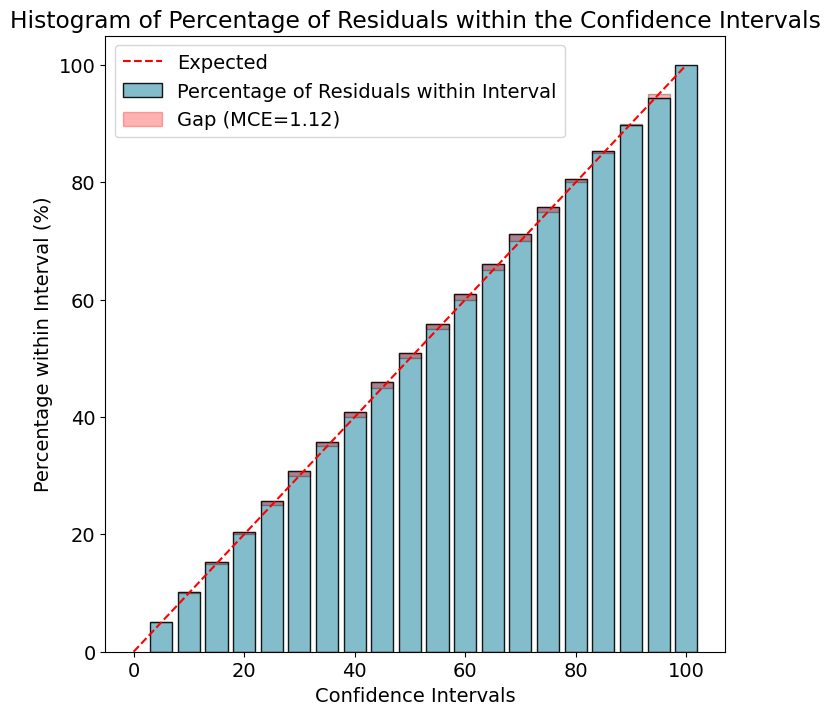

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

By comparing the two architecture it is clear that a separate set of features decreases the model's out-of-sample error. Therefore, the proposed model in the study is the first. 

Below are presented a set of model that have been tested as potential coompetitors to the finalized model above. They have been presented here as they represent more complicated ways of leveraging deep learning as a tool for normal behaviour modelling of wind turbines power curve. However, the increased complexity of the model did not who improvements in performance, therefore the simpler and more robust model presented above was chosen as th ebest candidate.

## Additional Models

### CNN with Gaussian Output

In light of a study conducted by et al. [2], we propose the use of a 1-D CNN to be used as an extractor of spatial features within out feature space. While this model is purely exploratory, we expect this not to excel, because of the almost non-existent spatial dependecy among features. In simpler terms, because CNNs capture spatial features, they are extremely dependent in the order of the features. In our case, the ordering of the features as little predictive significance, so the use of a convolution over the feature space of the input is not really empirically justified.

[2] Xiang, L., Wang, P., Yang, X., Hu, A., & Su, H. (2021). Fault de-
tection of wind turbine based on SCADA data analysis using CNN
and LSTM with an attention mechanism. Measurement, 175, 109094.
https://doi.org/10.1016/j.measurement.2021.109094

In [ ]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model_cnn_gaussian = create_model_cnn_gaussian(X_train_cnn, MODELS_SEED)
model_path = "cnn"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_cnn_gaussian,
                          X_train_cnn, y_train,
                          patience=15, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_cnn_gaussian.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_cnn_gaussian.evaluate(X_test_cnn, y_test)

In [ ]:
y_train_pred = np.array(model_cnn_gaussian(X_train_cnn).mean()).ravel()
y_test_pred = np.array(model_cnn_gaussian(X_test_cnn).mean()).ravel()

y_train_stddevs = np.array(model_cnn_gaussian(X_train_cnn).stddev()).ravel()
y_test_stddevs = np.array(model_cnn_gaussian(X_test_cnn).stddev()).ravel()

evaluate_and_save_metrics("Probabilistic CNN with Gaussian Output",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{model_path}/preds.png")

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{model_path}/cis.png")

Clearly, the model is underperforming as compared to the MLP model with Normal output. This is probably the case because the features extracted by the initial Convolution layer have little significanceas they are dependent on the ordering of the features, which have no spacial dependency. This means the subsequent layers have to unpack the convolution and pooling to learn meaningful features.  

## Modelling Multiple Turbines: a Multivariate Experiment

We present below an experiment consisting of multi-turbine modelling. The reasoning motivating this research comes from studying and modelling the correlation between different turbines and investigating whether this can improve the predictive performance of the multivariate model. Below are presented deep networks with multivariate outputs for the 6 turbines. The output is a multivariate Gaussian of which we model the mean vector and lower triangular matrix of its Cholesky decomposition. In this case, the negative log likelihood is:

$$
\text{NLL}(\mu, \Sigma) = \sum_{i=1}^{n} -\frac{1}{2} \left[ d \cdot \log(2\pi) + \log\left(|(\Sigma(\mathbf{x}_i))|\right) + (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)})^T (\Sigma(\mathbf{x}_i))^{-1} (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)}) \right]
$$

In [ ]:
def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

In [ ]:
# Specify the number of turbines to consider
turbine_num = 6

# Select the n turbines with the most common non-NaN data points
turbine_counts = df_train.groupby('turbine').apply(lambda x: x.notna().all(axis=1).sum())
turbine_ids = turbine_counts.nlargest(turbine_num).index.tolist()

df_top_n = df_train[df_train['turbine'].isin(turbine_ids)]
df_multivariate = flatten_dataframe(df_top_n, features, output_feature, DATETIME_COL)
df_multivariate.dropna(inplace=True)

In [ ]:
df_multivariate.head()

In [ ]:
output_feature_columns = [c for c in df_multivariate.columns if c.startswith(output_feature)]
feature_columns = list(set(df_multivariate.columns).difference(output_feature_columns))

X_train_mult, X_test_mult, y_train_mult, y_test_mult, scaler_x_mult = load_dataset_train_test_split(df_multivariate, feature_columns, output_feature_columns)
y_train_mult = np.array(y_train_mult)
y_test_mult = np.array(y_test_mult)

In [ ]:
print(X_train_mult.shape, y_train_mult.shape)

In [ ]:
# Number of turbines considered in the prediction
d = y_train_mult.shape[-1]
print("Number of turbines considered in the prediction: ", d)

### Diagonal Covariance Matrix

In this case, we investigate whether we can construct a model which is able to predict all means and variances simultaneously. In this simpler case we do not model covariances between turbines. BY enforcing a diagnonal covariance matrix of the outpyt Normal density we do not model covariances between different turbines, therefore the loss can be decomposed into a sum of individual losses as follows:

$$
\mathcal{L}_3 
= \mathcal{NLL}_d \\
= \frac{1}{2} \sum_{i=1}^{n}\left[ d \cdot \log(2\pi) + \log(|\boldsymbol{\Sigma}(\mathbf{x}_i^{\text{cnt}})|) + (\mathbf{y}_i - \boldsymbol{\mu}(\mathbf{x}_i^{\text{cnt}}))^T (\boldsymbol{\Sigma}^{-1}(\mathbf{x}_i^{\text{cnt}})) (\mathbf{y}_i - \boldsymbol{\mu}(\mathbf{x}_i^{\text{cnt}})) \right] \\
= \frac{1}{2} \sum_{i=1}^{n}  \left[ d \cdot \log(2\pi) + \sum_{j=1}^{d} \left[ \log(\sigma_{j}  (\mathbf{x}_i^{\text{cnt}})) +\sigma^{-2}_{j}(\mathbf{x}_i^{\text{cnt}})(\mathbf{y}_{ij} - \boldsymbol{\mu}_{j}(\mathbf{x}_i^{\text{cnt}}))^2 \right] \right] (\text{By diagonal form of $\boldsymbol{\Sigma}(\mathbf{x}_i^{\text{cnt}})$}) \\
= \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{d} \left[ \log(2\pi) + \log(\sigma_{j}  (\mathbf{x}_i^{\text{cnt}})) + \sigma^{-2}_{j}(\mathbf{x}_i^{\text{cnt}})(\mathbf{y}_{ij} - \boldsymbol{\mu}_{j}(\mathbf{x}_i^{\text{cnt}}))^2 \right]
$$


where $\boldsymbol{\Sigma}_{jj}(\mathbf{x}_i^{\text{cnt}}) = \sigma^{2}_{j}(\mathbf{x}_i^{\text{cnt}})$

Although the loss is separable, this is not identical to training individual models for each turbine because the input, and possibly network layers, are shared. We investigated two architectures with separate and shared hidden layers and showed that the architecture with separate hidden layers for each turbine produced better predictive results compared to the one with shared layers by allowing the network to learn turbine-specific features.

#### Separate Branches for Separate Turbines

In [ ]:
model_multivariate_gaussian_only_diagonal = create_model_multivariate_gaussian_only_diagonal(d, (X_train_mult.shape[1],), MODELS_SEED)
model_path = "mlp_mult_diag"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal,
                                X_train_mult, y_train_mult,
                                epochs=HUNDRED, patience=10, batch_size=32,
                                cp_callback=cp_callback,
                                seed=MODELS_SEED)
    
    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_only_diagonal.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_multivariate_gaussian_only_diagonal.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).covariance())

evaluate_and_save_metrics("Probabilistic Multivariate MLP (Only Diagonal, separate branches)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], save_path=f"figures/{model_path}/preds{i+1}.png")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_bar(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20, save_path=f"figures/{model_path}/cis{i+1}.png")

#### Common Branches for Separate Turbines

In [ ]:
model_multivariate_gaussian_only_diagonal_common = create_model_multivariate_gaussian_only_diagonal_common(d, (X_train_mult.shape[1],), MODELS_SEED)
model_path = "mlp_mult_diag_common"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/{model_path}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal_common,
                                X_train_mult, y_train_mult,
                                epochs=HUNDRED, patience=10, batch_size=32,
                                cp_callback=cp_callback,
                                seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_only_diagonal_common.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_multivariate_gaussian_only_diagonal_common.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).covariance())

evaluate_and_save_metrics("Probabilistic Multivariate MLP (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_bar(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

### Full Covariance Matrix: Lower Triangular Cholesky Decomposed Covariance Matrix

In the model presented below we model the full covariance matrix of a gaussian distribution. In the world of real numbers, covariance matrices are symmetric and positive-definite. To enforce this we only parametrize a lower triangular matrix as part the Cholesky decomposition of the final full covariance matrix. Therefore, for $d$ turbines, we need $d$ output units for the predicted mean vector and $d(d-1)/2$ for the predicted covariance. So $d(d+1)/2$ in total.

In [ ]:
model_multivariate_gaussian_with_covariance = create_model_multivariate_gaussian_with_covariance(d, (X_train_mult.shape[1],), MODELS_SEED)
model_path = "mlp_mult_full"

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/{model_path}.weights.h5",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_with_covariance,
                                X_train_mult, y_train_mult,
                                epochs=HUNDRED, patience=10, batch_size=32,
                                cp_callback=cp_callback,
                                seed=MODELS_SEED)

    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_with_covariance.load_weights(f"saved_models/{model_path}.weights.h5")

In [ ]:
model_multivariate_gaussian_with_covariance.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).covariance())

evaluate_and_save_metrics("Probabilistic Multivariate MLP (Lower Triangular Covariance Matrix)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print("turbine #", i+1, "- RMSE:", sqrt(err))

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], save_path=f"figures/{model_path}/preds{i+1}.png")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_bar(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20, save_path=f"figures/{model_path}/cis{i+1}.png")

While we acknowledge that these multivariate models do not perform as accurately as its univariate counterparts, the exploration of this multivariate study leads to believe that, with larger data sets and greater computational resources, larger probabilistic networks could be trained to perform a probabilistic deep learning multivariate normal behaviour modelling of the power output of entire wind farms. This is something that, to the author's knowledge, has never been achieved before. In particular the limited data set of 73k data points for a very large number of tunable parameters, for example more than 150k in the network modelling covariance, does not allow for sufficiently reduced predictive variance, quantified in the amount of variation of the target function when considering a different dataset, of the network given its large capacity. 

## Wind Farm Pre-training and Wind Turbine Fine-tuning: An Ablation Study

We perform an ablation stidy to evaluate if scaling the architecture and/or wind farm data pre-training can improve the predictive performance. To do so we present a larger MLP architecture and we compare the results between the Probabilistic MLP (see above) and the following models:

1. Probabilistic MLP with pre-training
2. Large Probabilistic MLP without pre-training
3. Large Probabilistic MLP with pre-training

Additionally, we investigate how well does pre-training bootstrap performance for newly installed turbines. To do so we remove WT5 data from the pre-training data set and we fine-tune six different models from the pre-training weights each with a mutually exclusive and consecutive sample of data from the data set. Each sample is taken to be two consecutive months worth of data, excluding filtering. These six fine-tuning data sets range in size between X and X.

### 1. Probabilistic MLP with pre-training

In [ ]:
# Define the file path for saving the weights
checkpoint_path = 'saved_models/mlp_pretrained.weights.h5'

# Train the initial model using X_full with the checkpoint callback
mlp_pretrained = create_model_mlp_gaussian_joint(X_train_full, MODELS_SEED)
mlp_pretrained.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 100)                  3500      ['input_2[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 80)                   8080      ['dense_8[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 40)                   3240      ['dense_9[0][0]']             
                                                                                            

In [ ]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

start_epoch = 0

if TRAIN == True:
    history = mlp_pretrained.fit(X_train_full, y_train_full, epochs=5*HUNDRED, batch_size=64, initial_epoch=start_epoch,
                                validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
    plot_loss_history(history)

In [ ]:
mlp_pretrained.load_weights(checkpoint_path)
evaluation = mlp_pretrained.evaluate(X_test_full, y_test_full)

6311/6311 [==============================] - 20s 3ms/step - loss: 10.6901


In [ ]:
checkpoint_path = 'saved_models/mlp_finetuned.keras'
mlp_finetuned = mlp_pretrained
mlp_pretrained.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 100)                  3500      ['input_2[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 80)                   8080      ['dense_8[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 40)                   3240      ['dense_9[0][0]']             
                                                                                            

Epoch 1/50
4262/4262 [==============================] - 3s 669us/step - loss: 3.7246 - val_loss: 3.7290
Epoch 2/50
4262/4262 [==============================] - 3s 656us/step - loss: 3.6880 - val_loss: 3.6907
Epoch 3/50
4262/4262 [==============================] - 3s 645us/step - loss: 3.6782 - val_loss: 3.6744
Epoch 4/50
4262/4262 [==============================] - 3s 639us/step - loss: 3.6737 - val_loss: 3.6645
Epoch 5/50
4262/4262 [==============================] - 3s 646us/step - loss: 3.6637 - val_loss: 3.6787
Epoch 6/50
4262/4262 [==============================] - 3s 642us/step - loss: 3.6605 - val_loss: 3.7213
Epoch 7/50
4262/4262 [==============================] - 3s 637us/step - loss: 3.6566 - val_loss: 3.7234
Epoch 8/50
4262/4262 [==============================] - 3s 635us/step - loss: 3.6541 - val_loss: 3.7110
Epoch 9/50
4262/4262 [==============================] - 3s 645us/step - loss: 3.6520 - val_loss: 3.7035
Epoch 10/50
4262/4262 [==============================] - 3s 640u

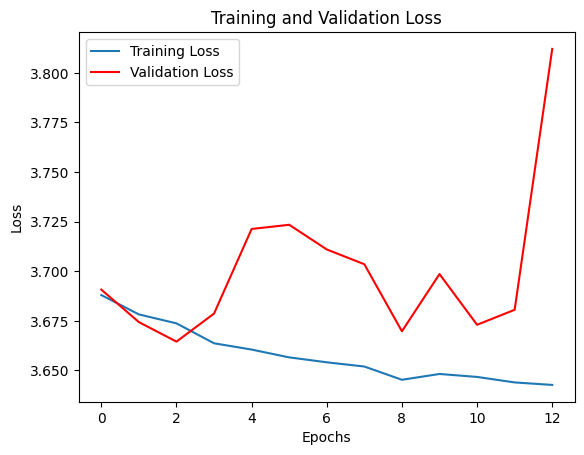

In [ ]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

if TRAIN == True:
    history = mlp_finetuned.fit(X_train, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
    plot_loss_history(history)

In [ ]:
mlp_finetuned.load_weights(checkpoint_path)
evaluation = mlp_finetuned.evaluate(X_test, y_test)
print("Evaluation Loss:", evaluation)

1184/1184 [==============================] - 5s 4ms/step - loss: 3.6588
Evaluation Loss: 3.6587564945220947


In [ ]:
y_train_pred = np.array(mlp_finetuned(X_train).mean()).ravel()
y_test_pred = np.array(mlp_finetuned(X_test).mean()).ravel()

y_train_stddevs = np.array(mlp_finetuned(X_train).stddev()).ravel()
y_test_stddevs = np.array(mlp_finetuned(X_test).stddev()).ravel()

name = "Prob. MLP (Fine-tuned)"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
    y_train, y_test, y_train_pred, y_test_pred,
    y_train_stddevs, y_test_stddevs, 0.99)

c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\safe\utils.py:398: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_existing = pd.read_csv(filename)


Train RMSE: 25.375
Test RMSE: 25.827
Train MAE: 13.589
Test MAE: 13.801
Percentage of Test Data Points within 99.00% CI: 98.76%
Percentage of Test Data Points within 99.00% CI: 98.52%
Percentage of Test Data Points within 99.00% CI: 95.76%
Percentage of Test Data Points within 99.00% CI: 95.19%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


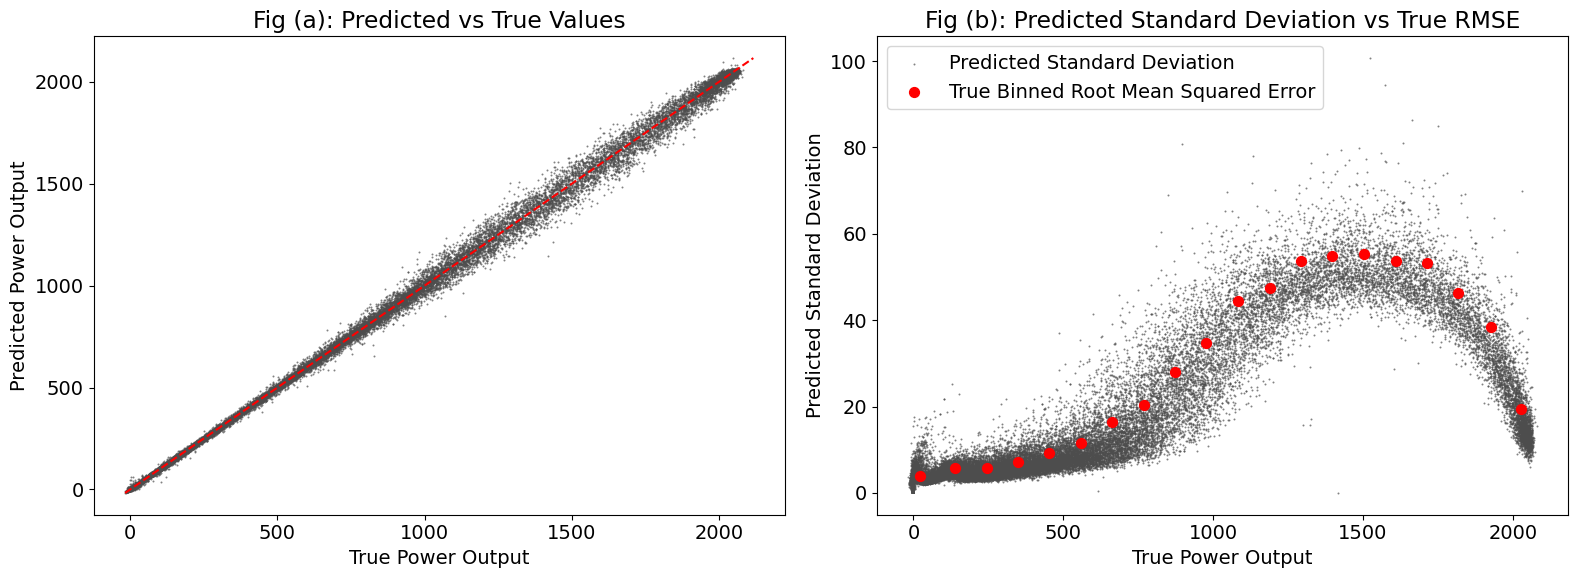

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

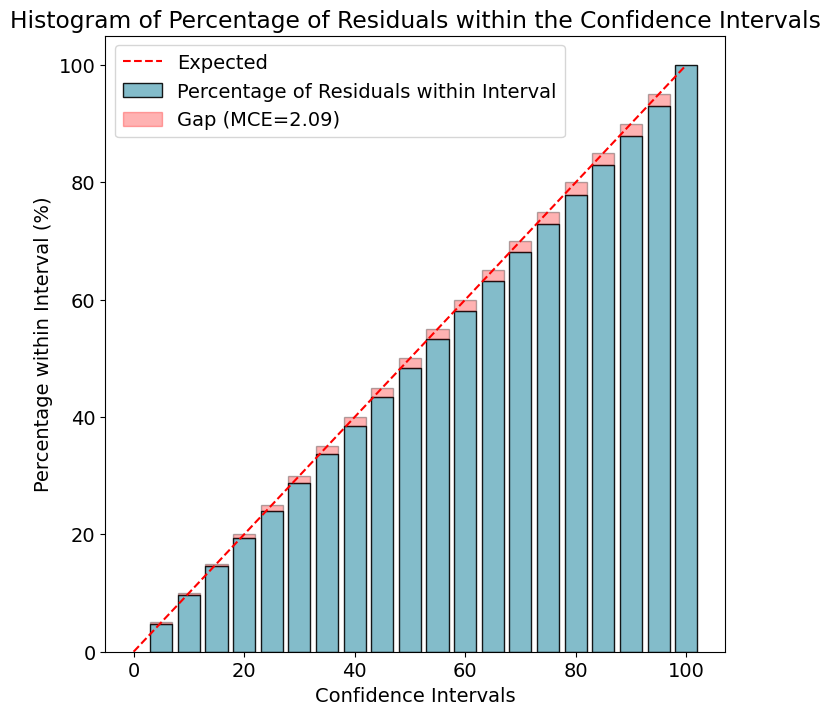

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20)

### 2. Large Probabilistic MLP without pre-training

In [ ]:
# Define the file path for saving the weights
checkpoint_path = 'saved_models/mlp_large.weights.h5'

# Train the initial model using X_full with the checkpoint callback
mlp_large = create_model_mlp_gaussian_large(X_train_full, MODELS_SEED)
mlp_large.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_20 (Dense)            (None, 300)               10500     
                                                                 
 dense_21 (Dense)            (None, 200)               60200     
                                                                 
 dense_22 (Dense)            (None, 100)               20100     
                                                                 
 dense_23 (Dense)            (None, 2)                 202       
                                                                 
 distribution_lambda_3 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                           

In [ ]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

if TRAIN == True:
    history = mlp_large.fit(X_train, y_train, epochs=HUNDRED, batch_size=64,
                            validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
    plot_loss_history(history)                        

Epoch 1/100
2128/2131 [============================>.] - ETA: 0s - loss: 6.4300

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [ ]:
mlp_large.load_weights(checkpoint_path)
evaluation = mlp_large.evaluate(X_test, y_test)

ValueError: Layer 'loss' expected 2 variables, but received 0 variables during loading. Expected: ['total:0', 'count:0']

In [ ]:
y_train_pred = np.array(mlp_large(X_train).mean()).ravel()
y_test_pred = np.array(mlp_large(X_test).mean()).ravel()

y_train_stddevs = np.array(mlp_large(X_train).stddev()).ravel()
y_test_stddevs = np.array(mlp_large(X_test).stddev()).ravel()

name = "Large Prob. MLP"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
    y_train, y_test, y_train_pred, y_test_pred,
    y_train_stddevs, y_test_stddevs, 0.99)

Train RMSE: 24.404
Test RMSE: 26.091
Train MAE: 13.287
Test MAE: 14.167
99.13%
98.19%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


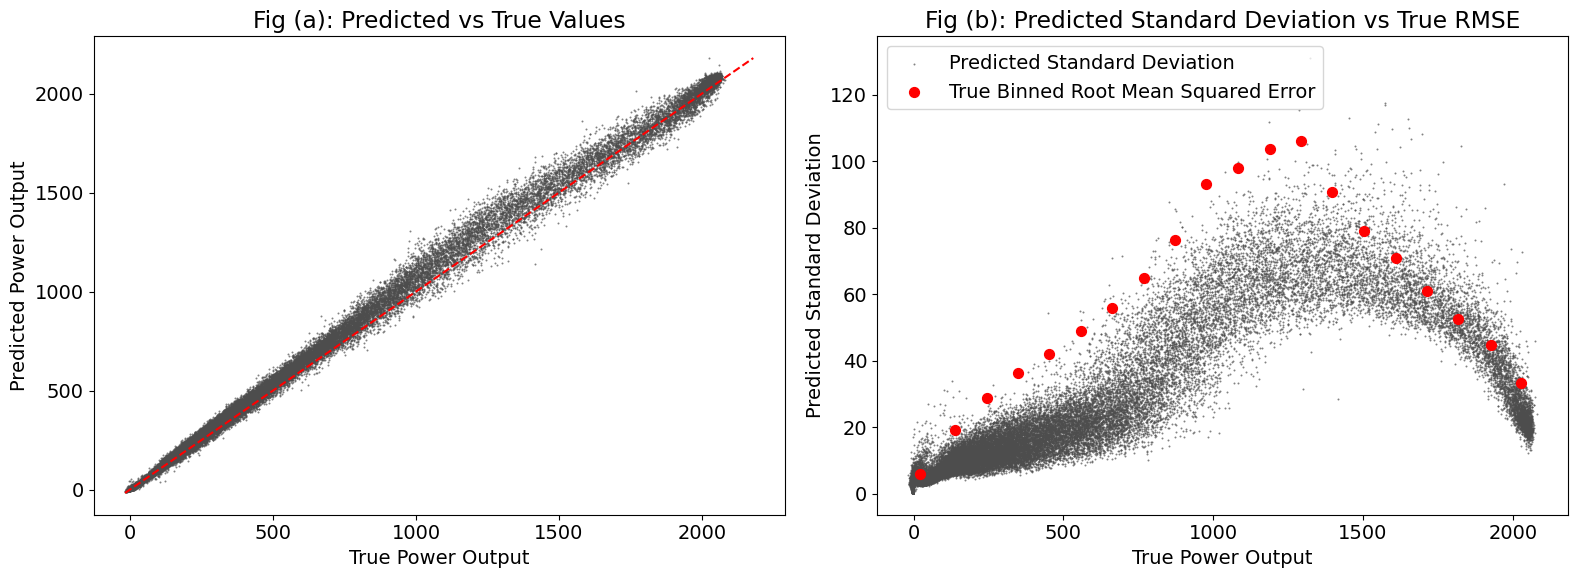

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

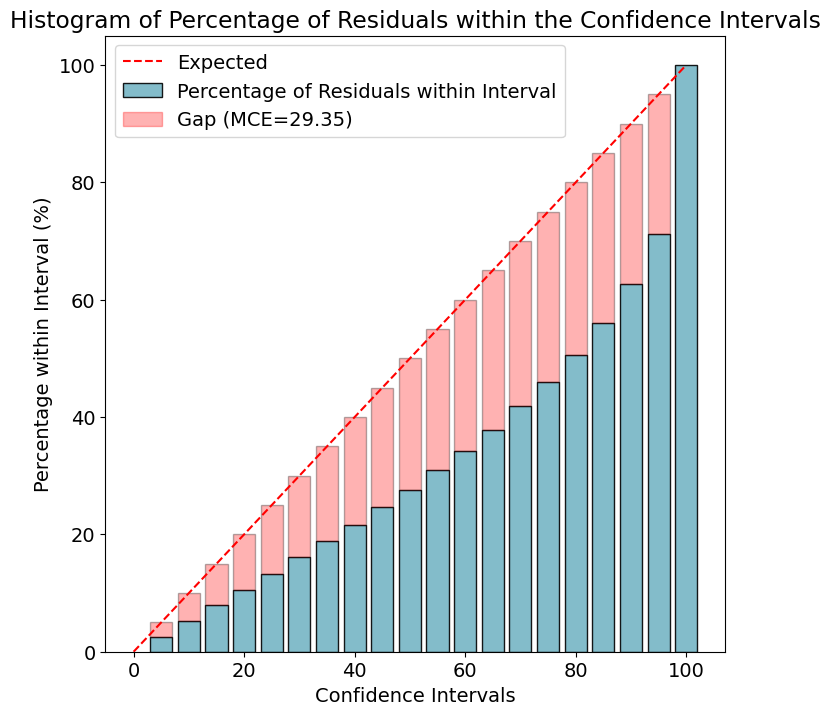

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20)

### 3. Large Probabilistic MLP with pre-training

In [ ]:
# Define the file path for saving the weights
checkpoint_path = 'saved_models/mlp_large_pretrained.weights.h5'

# Train the initial model using X_full with the checkpoint callback
mlp_large_pretrained = create_model_mlp_gaussian_large(X_train_full, MODELS_SEED)
mlp_large_pretrained.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_24 (Dense)            (None, 300)               10500     
                                                                 
 dense_25 (Dense)            (None, 200)               60200     
                                                                 
 dense_26 (Dense)            (None, 100)               20100     
                                                                 
 dense_27 (Dense)            (None, 2)                 202       
                                                                 
 distribution_lambda_6 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                           

In [ ]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Load weights from the checkpoint if available
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Loading weights.")
    mlp_large_pretrained.load_weights(checkpoint_path)
    # Get the number of epochs already run
    try:
        start_epoch = mlp_large_pretrained.history.epoch[-1]
    except:
        start_epoch = 0
    print(f"Resuming training from epoch {start_epoch}.")
else:
    print("No checkpoint found. Training from scratch.")
    start_epoch = 0

if TRAIN == True:
    history = mlp_large_pretrained.fit(X_train_full, y_train_full, epochs=5*HUNDRED, batch_size=64, initial_epoch=start_epoch,
                            validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
    plot_loss_history(history)

Checkpoint found. Loading weights.
Resuming training from epoch 0.
Epoch 1/500
11360/11360 [==============================] - 10s 833us/step - loss: 3.9464 - val_loss: 3.9606
Epoch 2/500
11360/11360 [==============================] - 9s 821us/step - loss: 3.9348 - val_loss: 3.9363
Epoch 3/500
11360/11360 [==============================] - 9s 808us/step - loss: 3.9236 - val_loss: 3.9186
Epoch 4/500
11360/11360 [==============================] - 9s 811us/step - loss: 3.9109 - val_loss: 4.1239
Epoch 5/500
11360/11360 [==============================] - 9s 812us/step - loss: 3.9007 - val_loss: 3.9149
Epoch 6/500
11360/11360 [==============================] - 9s 806us/step - loss: 3.8915 - val_loss: 4.0893
Epoch 7/500
11360/11360 [==============================] - 9s 820us/step - loss: 3.8844 - val_loss: 3.8963
Epoch 8/500
11360/11360 [==============================] - 9s 798us/step - loss: 3.8758 - val_loss: 3.9536
Epoch 9/500
11360/11360 [==============================] - 11s 940us/step - 

In [ ]:
mlp_large_pretrained.load_weights(checkpoint_path)
evaluation = mlp_large_pretrained.evaluate(X_test_full, y_test_full)

6311/6311 [==============================] - 2s 345us/step - loss: 3.7156


In [ ]:
checkpoint_path = 'saved_models/mlp_large_finetuned.keras'

mlp_large_finetuned = create_model_finetune(X_train, mlp_large_pretrained, MODELS_SEED)
mlp_large_finetuned.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_24 (Dense)            (None, 300)               10500     
                                                                 
 dense_25 (Dense)            (None, 200)               60200     
                                                                 
 dense_26 (Dense)            (None, 100)               20100     
                                                                 
 dense_27 (Dense)            (None, 2)                 202       
                                                                 
 distribution_lambda_6 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                           

Epoch 1/50
4262/4262 [==============================] - 3s 740us/step - loss: 3.7295 - val_loss: 3.6134
Epoch 2/50
4262/4262 [==============================] - 3s 702us/step - loss: 3.5852 - val_loss: 3.5714
Epoch 3/50
4262/4262 [==============================] - 3s 714us/step - loss: 3.5585 - val_loss: 3.5706
Epoch 4/50
4262/4262 [==============================] - 3s 738us/step - loss: 3.5441 - val_loss: 3.5589
Epoch 5/50
4262/4262 [==============================] - 3s 721us/step - loss: 3.5333 - val_loss: 3.5445
Epoch 6/50
4262/4262 [==============================] - 3s 719us/step - loss: 3.5262 - val_loss: 3.5488
Epoch 7/50
4262/4262 [==============================] - 3s 727us/step - loss: 3.5192 - val_loss: 3.5374
Epoch 8/50
4262/4262 [==============================] - 3s 707us/step - loss: 3.5148 - val_loss: 3.5439
Epoch 9/50
4262/4262 [==============================] - 3s 706us/step - loss: 3.5103 - val_loss: 3.5383
Epoch 10/50
4262/4262 [==============================] - 3s 716u

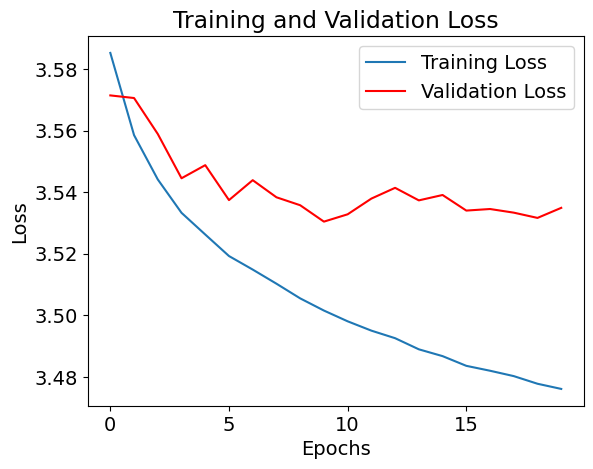

In [ ]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

if TRAIN == True:
    history = mlp_large_finetuned.fit(X_train, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
    plot_loss_history(history)

In [ ]:
mlp_large_finetuned.load_weights(checkpoint_path)
evaluation = mlp_large_finetuned.evaluate(X_test, y_test)

1184/1184 [==============================] - 0s 360us/step - loss: 3.5720


In [ ]:
y_train_pred = np.array(mlp_large_finetuned(X_train).mean()).ravel()
y_test_pred = np.array(mlp_large_finetuned(X_test).mean()).ravel()

y_train_stddevs = np.array(mlp_large_finetuned(X_train).stddev()).ravel()
y_test_stddevs = np.array(mlp_large_finetuned(X_test).stddev()).ravel()

name = "Large MLP (Fine-tuned)"

save_preds(name, y_test_pred, y_test_stddevs)

evaluate_and_save_metrics(name,
    y_train, y_test, y_train_pred, y_test_pred,
    y_train_stddevs, y_test_stddevs, 0.99)

Train RMSE: 22.429
Test RMSE: 23.728
Train MAE: 11.993
Test MAE: 12.672
98.72%
97.85%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


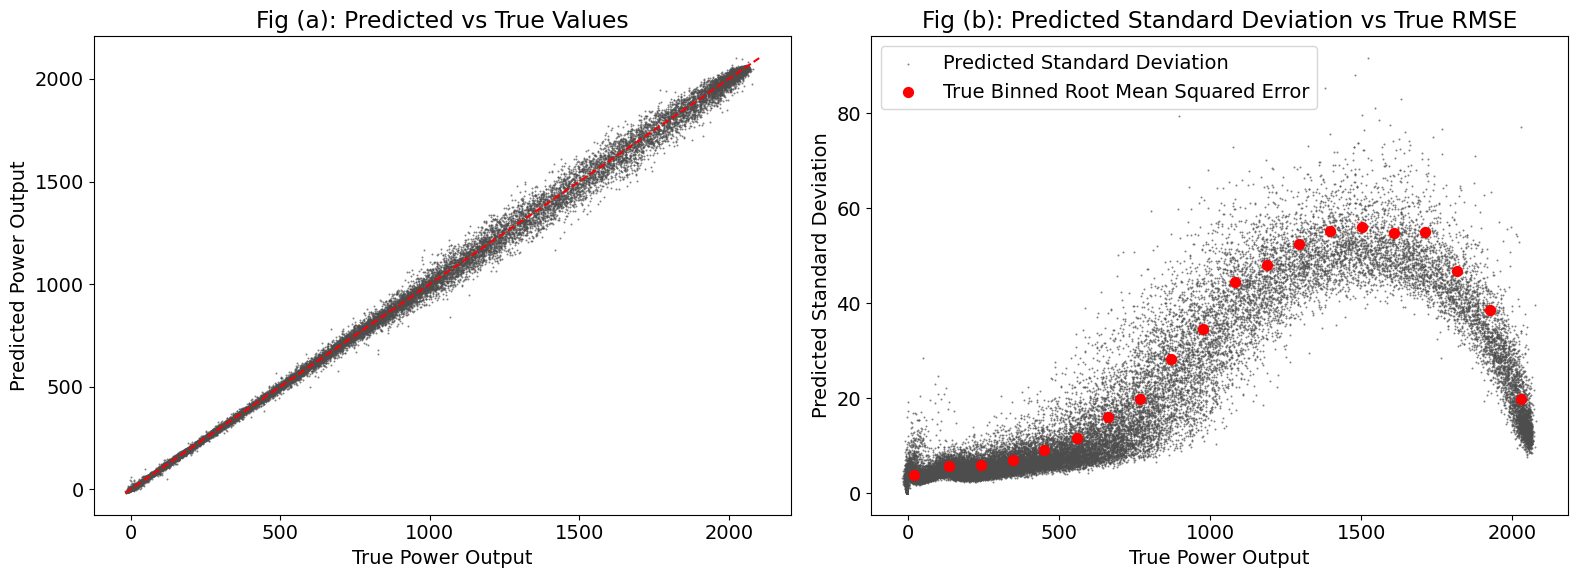

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

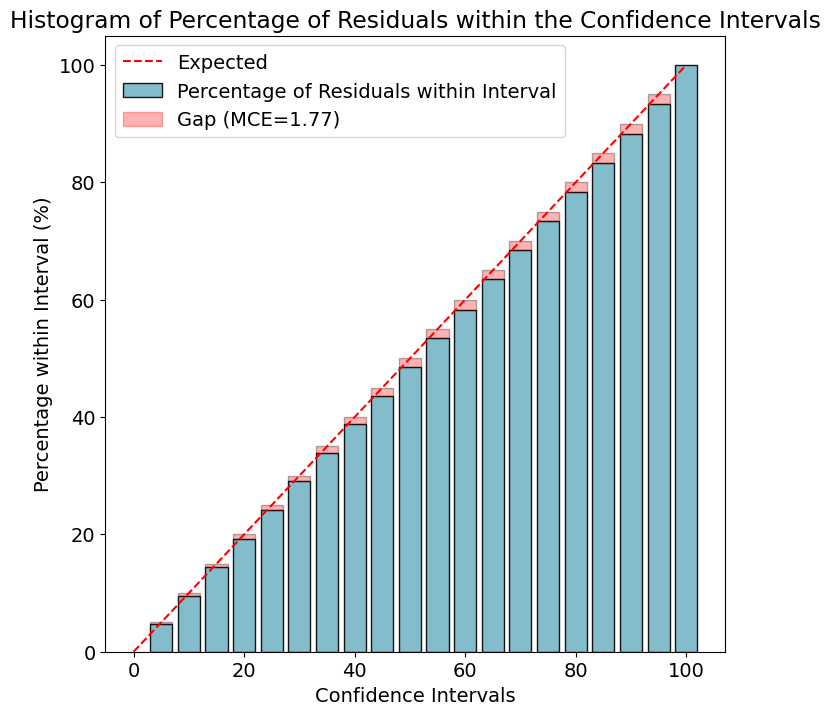

In [ ]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20)

## Results

In [ ]:
results = pd.read_csv('results.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: Fine-tuned
Train RMSE                                         22.22
Train MAE                                          11.88
Test RMSE                                          23.72
Test MAE                                           12.6
Test % within 99.00% CI                            97.73


Model: Large Probabilistic MLP
Train RMSE                                         23.84
Train MAE                                          12.85
Test RMSE                                          25.61
Test MAE                                           13.84
Test % within 99.00% CI                            97.63


Model: Non-probabilistic MLP
Train RMSE                                         27.27
Train MAE                                          16.32
Test RMSE                                          27.85
Test MAE                                           16.59
Test % within 99.00% CI                            96.24


Model: Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Train

In [ ]:
results = pd.read_csv('results.csv')

# Get the list of metrics
metrics = results.columns[1:]

# Print results
for idx, row in results.iterrows():
    # print(row['Model Name'])
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass  # If conversion fails, keep the original value
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = row['Model Name'] + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")


Fine-tuned 22.22 & 11.88 & 23.72 & 12.60 & 97.73\% \\


Large Probabilistic MLP 23.84 & 12.85 & 25.61 & 13.84 & 97.63\% \\


Non-probabilistic MLP 27.27 & 16.32 & 27.85 & 16.59 & 96.24\% \\


Epistemic Uncertainty BNN (Flipout) - 1.0% Sample 124.99 & 92.54 & 124.93 & 92.37 & 17.17\% \\


Epistemic Uncertainty BNN (Flipout) 29.38 & 18.11 & 29.75 & 18.28 & 25.64\% \\


Prob. MLP (Fine-tuned) 22.08 & 11.83 & 23.58 & 12.63 & 97.75\% \\


Large Prob. MLP 24.40 & 13.29 & 26.09 & 14.17 & 98.19\% \\


Large MLP (Fine-tuned) 22.43 & 11.99 & 23.73 & 12.67 & 97.85\% \\




## Deep Neural Network with Gaussian Output (Joint Submodels) - Averaged over Seeds

We average our proposed model over 5 different random seed for initializing the vector weight to show that our model is robust to the randomness of weight initialization. We demonstrate this by showing a very low standard deviation over the sample set.

In [ ]:
SEED_BIAS_CHECK = False
if SEED_BIAS_CHECK:
    rmses = []
    maes = []
    percentages = []
    NUM_SEED = 5

    for seed in range(NUM_SEED):
        model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, seed)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=overwrite(f"saved_models/model_mlp_gaussian_joint_{seed}.weights.h5"),
                                                     save_weights_only=True,
                                                     verbose=0)
        history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

        z_value = stats.norm.ppf((1 + CONFIDENCE_INTERVAL) / 2)

        y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()
        y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = np.sqrt(mean_absolute_error(y_test, y_test_pred))

        test_lower_bound = y_test_pred - z_value * y_test_stddevs
        test_upper_bound = y_test_pred + z_value * y_test_stddevs

        test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))
        test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

        rmses.append(test_rmse)
        maes.append(test_mae)
        percentages.append(test_percentage_within_interval)
        
    

SyntaxError: invalid syntax (619880660.py, line 16)

In [ ]:
if SEED_BIAS_CHECK == True:
    print(f"Mean of RMSEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of RMSEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of MAEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of MAEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).std()}")

As predicted, the RMSE is inline with what we had for a single seed, moreover, the standard deviation is very low. This shows how our model is robust to the randomness of the weight initialization.